In [1]:
!pip install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import torch
from torch import nn
import torch.distributions as dist
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
import math
import os
import arviz as az
%matplotlib inline

from networks import *

import seaborn as sns
sns.set_style("white")
plt.rcParams.update({'font.size': 9})

import warnings
warnings.filterwarnings("ignore")

np.random.seed(37)
torch.manual_seed(37)

## Propagating Uncertainty Through a Differential Equation
Consider the steady state heat equation on a heterogeneous rod with no heat sources:
$$
\frac{d}{dx}\left(a(x)\frac{d}{dx}u(x)\right) = 0,
$$
and boundary values:
$$
u(0) = 1\;\mbox{and}\;u(1) = 0.
$$
We are interested in cases in which we are uncertain about the conductivity, $a(x)$.
Before we proceed, we need to put together all our prior beliefs and come up with a stochastic model for $a(x)$ that represents our uncertainty.
This requires assigning a probability measure on a function space.
For now, we will just give you a model.
We will model $a = a(x;\boldsymbol{\xi})$ as:
$$
a(x;\boldsymbol{\xi}) = \exp\{g(x;\boldsymbol{\xi})\},
$$
where  $g(x;\boldsymbol{\xi})$ is a random field.
The reason for the exponential is that $a(x;\boldsymbol{\xi})$ must be positive.
We will assume that the random field ia a [Wiener-Lévy process](https://en.wikipedia.org/wiki/Wiener_process).
This is a field that it is no-where continuous and it is actually a fractal (when you zoom in the spatial dimension, the field resembles itself at a larger scale).
The Karhunen-Loeve expansion of the field is:
$$
g(x;\boldsymbol{\xi}) = \sum_{i=1}^d\xi_i\phi_i(x),
$$
where $\phi_i(x)$ are the eigenfunctions of $x$ and $\xi_i$ are independent standard normal random variables with zero mean and unit variance.
For this particular example, we will assume that:
$$
\phi_i(x) = \frac{\sqrt{2}\sigma}{(i - \frac{1}{2})\pi}\sin\left((i-\frac{1}{2})\pi x\right),
$$
where $\sigma>0$ is a parameter controlling the variance of the random field.

The field is implemented as function 'g'.

## Inverse problem
$$p(\boldsymbol{\xi}|\textbf{y}) \propto p(\textbf{y}|\boldsymbol{\xi}) p(\boldsymbol{\xi})$$
$$\text{Prior: } p(\xi) = N(0, I)$$
$$\text{Likelihood: } p(\textbf{y}|\boldsymbol{\xi}) =  N(\textbf{y}| f(x, \boldsymbol{\xi}), \gamma^2); \gamma = 0.015$$
$$\text{Approximate posterior: }q(\boldsymbol{\xi}|\textbf{y})$$

In [3]:
# Defining prior distribution
d_xi = 5 #  number of terms to consider

prior_xi_dist = dist.Normal(loc=torch.zeros(d_xi), scale=torch.ones(d_xi))

In [4]:
x_gt = torch.linspace(0., 1, 100)
x_ticks = torch.linspace(0.15, 0.85, 9) # Measurements of output at this x-locations
print(x_ticks)

tensor([0.1500, 0.2375, 0.3250, 0.4125, 0.5000, 0.5875, 0.6750, 0.7625, 0.8500])


In [5]:
# loading trained pinn model
pinn_state_dict = torch.load('model_state_dict_pinn.pt')
pinn = DenseResNet(dim_in=1+(d_xi), dim_out=1, num_resnet_blocks=5, 
                 num_layers_per_block=3, num_neurons=40, activation=nn.SiLU())
pinn.load_state_dict(pinn_state_dict)

B1 = 1 # boundary_value_left
B2 = 0 # boundary_value_right
u_trail = lambda x, inputs, net: (B1*(1-x))+(B2*x)+(x*(1-x)*net(inputs))


def forward_process(xi): # N x d_xi
    """
    Implements the forward process f(xi) and 
    returns the output field values at the measurement locations.
    """
    xi = xi.reshape(-1,d_xi)
    outputs = torch.zeros(xi.shape[0], len(x_ticks))
    for i in range(xi.shape[0]):
        inputs_i = torch.hstack([x_ticks.reshape(-1,1), xi[i].repeat(len(x_ticks),1)])
        u_pred_i = u_trail(x_ticks.reshape(-1,1), inputs_i, pinn) 
        outputs[i] = u_pred_i.flatten()
    return outputs

In [6]:
class ResNet(torch.nn.Module):
    """
    Implements the residual network
    """
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs

In [7]:
def unpack_cholesky(L_diag, L_offdiag, xi_dim):
    """
    Constructs cholesky L matrix from diagonal and offdiagonal elements.
    """
    chol_diag = torch.diag(L_diag)
    
    chol_offdiag = torch.zeros((xi_dim, xi_dim))
    tril_indices = torch.tril_indices(row=xi_dim, col=xi_dim, offset=-1)
    chol_offdiag[tril_indices[0], tril_indices[1]] = L_offdiag

    q_L = chol_diag + chol_offdiag # here q_L is L matrix
    return q_L 

In [8]:
class Amortized_VI(nn.Module):
    """
    Class that performs Amortized Variational inference.
    xi_dim: Number of dimensions in the variables to infer.
    y_dim: Number of measurement observations.
    prior_xi_dist: prior distribution defined using torch.distributions.
    f: function defining the forward process.
    noise_scale: Standard deviation of likelihood or the measurement process.
    """
    def __init__(self, xi_dim=2*5, y_dim=1, prior_xi_dist=None, f=forward_process, noise_scale=0.02):
        super().__init__()
        
        self.xi_dim = xi_dim
        self.y_dim = y_dim
        self.prior_xi_dist = prior_xi_dist
        self.f = f
        self.noise_scale = noise_scale
        
        self.mu = nn.Sequential(
            nn.Linear(self.y_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 40),
            nn.ReLU(),
            nn.Linear(40, 30),
            nn.ReLU(),
            nn.Linear(30, 20),
            nn.ReLU(),
            nn.Linear(20, self.xi_dim))
        
        self.L_diag = nn.Sequential(
            nn.Linear(self.y_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 40),
            nn.ReLU(),
            nn.Linear(40, 30),
            nn.ReLU(),
            nn.Linear(30, 20),
            nn.ReLU(),
            nn.Linear(20, self.xi_dim),
            nn.Softplus()
        )
        
        self.L_offdiag = nn.Sequential(
            nn.Linear(self.y_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 40),
            nn.ReLU(),
            nn.Linear(40, 30),
            nn.ReLU(),
            nn.Linear(30, 20),
            nn.ReLU(),
            nn.Linear(20, int(self.xi_dim*(self.xi_dim+1)/2)-self.xi_dim)
        )
        
    def observed_data(self, n=30):
        xi_data = self.prior_xi_dist.sample([n])  
        y_data = self.f(xi_data) + self.noise_scale * torch.randn(*self.f(xi_data).shape)

        return xi_data, y_data
    
    def forward(self, num_particles=2):
        _, y = self.observed_data(n=64)
        
        q_mu = self.mu(y)
        q_L_diag = self.L_diag(y)
        q_L_offdiag = self.L_offdiag(y) #or 0.01*self.L_offdiag(y)

        #print(q_mu, q_L_diag, q_L_offdiag)
        
        loss = 0
        for j in range(y.shape[0]):
            
            ##### elbo for one data point 
            q_Lj = unpack_cholesky(q_L_diag[j,:], q_L_offdiag[j,:], self.xi_dim) # q_Lj is L matrix    
            
            xi_samples = torch.zeros(num_particles, self.xi_dim)
            for k in range(num_particles):
                zs = torch.randn_like(q_mu[j,:])
                xi_samples[k] = q_mu[j,:] + torch.matmul(q_Lj, zs)# reparametrization

            datafit = 0.
            for i in range(num_particles):
                log_prior = self.prior_xi_dist.log_prob(xi_samples[i]).sum()
                log_likelihood = dist.Normal(loc=self.f(xi_samples[i])[0], scale=self.noise_scale).log_prob(y[j,:]).sum()
                log_joint = log_prior + log_likelihood
                # print(log_prior, log_likelihood)
                datafit += log_joint
            datafit = datafit/num_particles

            entropy = dist.MultivariateNormal(loc=q_mu[j,:], scale_tril=q_Lj).entropy()
            # print(entropy)
            elbo = datafit + entropy
            #####
            loss += elbo
        
        return loss/y.shape[0]

step 0: loss = 674, learning rate = 0.00100
step 500: loss = 18, learning rate = 0.00100
step 1000: loss = 6, learning rate = 0.00100
step 1500: loss = -9, learning rate = 0.00100
step 2000: loss = -10, learning rate = 0.00100
step 2500: loss = -10, learning rate = 0.00100
step 3000: loss = -12, learning rate = 0.00100
step 3500: loss = -10, learning rate = 0.00100
step 4000: loss = -10, learning rate = 0.00100
step 4500: loss = -9, learning rate = 0.00100
step 5000: loss = -10, learning rate = 0.00100
step 5500: loss = -15, learning rate = 0.00100
step 6000: loss = -15, learning rate = 0.00100
step 6500: loss = -16, learning rate = 0.00100
step 7000: loss = -15, learning rate = 0.00100
step 7500: loss = -15, learning rate = 0.00100
step 8000: loss = -15, learning rate = 0.00100
step 8500: loss = -15, learning rate = 0.00100
step 9000: loss = -15, learning rate = 0.00100
step 9500: loss = -16, learning rate = 0.00100
step 10000: loss = -16, learning rate = 0.00100
step 10500: loss = -1

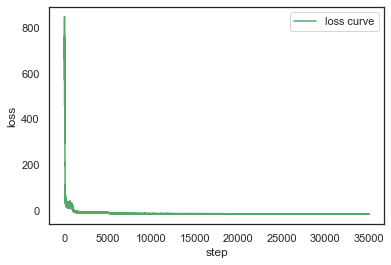

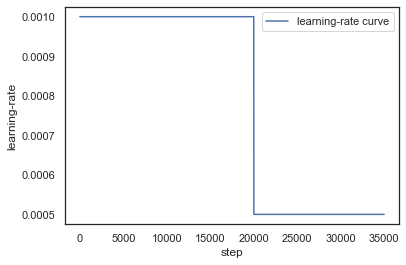

In [9]:
noise_scale = 0.015
model = Amortized_VI(xi_dim=d_xi, y_dim=len(x_ticks), prior_xi_dist=prior_xi_dist, f=forward_process, noise_scale=noise_scale)

# Training
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=20000, gamma=0.5)

n_steps = 35000

steps, losses, learning_rates = [], [], []
for step in range(n_steps):
    optim.zero_grad()
    loss = - model(num_particles=5)
    loss.backward()
    # torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optim.step()
    scheduler.step()
    
    steps.append(step)
    losses.append(loss.item())
    learning_rates.append(optim.state_dict()['param_groups'][0]['lr'])
    
    if step % 500 == 0: 
        print('step %s:' % step, 'loss = %.0f,' % loss, 
              'learning rate = %.5f' % optim.state_dict()['param_groups'][0]['lr']) 
        
plt.figure()
plt.plot(steps, losses, 'g', label = 'loss curve')
plt.xlabel('step')
plt.ylabel('loss')
plt.legend()

plt.figure()
plt.plot(steps, learning_rates, 'b', label = 'learning-rate curve')
plt.xlabel('step')
plt.ylabel('learning-rate')
plt.legend()

In [10]:
save = True
if save==True:
    torch.save(model.state_dict(), 'model_state_dict_AVI.pt')

In [11]:
noise_scale = 0.015
model = Amortized_VI(xi_dim=d_xi, y_dim=len(x_ticks), prior_xi_dist=prior_xi_dist, f=forward_process, noise_scale=noise_scale)
model.load_state_dict(torch.load('model_state_dict_AVI.pt'))

<All keys matched successfully>

In [12]:
# This computes the random field given a xi
def g(x, xi, sigma=1.):
    """
    Arguments:
    x     -   Column containing the points at which you wish to evaluate the field.
    xi    -   Array of the random variables. The number of columns correspond to 
              corresponds to the ``d`` in the math above.
    sigma -   This is the variance of the field.
    """
    res = torch.zeros((xi.shape[0], 1))
    d = xi.shape[1]
    for i in range(1, d+1):
        res += xi[:, i-1].reshape(-1,1) * math.sqrt(2) * sigma * torch.sin((i - .5) * math.pi * x) / ((i - .5) * math.pi)
    return res

In [13]:
def trajectories_from_parameters(xi): 
    inputs = torch.hstack([x_gt.reshape(-1,1), xi.repeat(len(x_gt),1)])
    u_pred = u_trail(x_gt.reshape(-1,1), inputs, pinn)  
    return u_pred

In [14]:
def plot(xi_samples, xi_data, y_data, j, title):
    
    fig = plt.figure(figsize=(12,4))
    
    ax1 = fig.add_subplot(1, 2, 1)
    # corresponding input field samples
    sigma = 1.5
    ax1.plot(x_gt.reshape(-1, 1), g(x_gt.reshape(-1, 1),xi_data[0].repeat(len(x_gt),1),sigma=sigma).detach().numpy(), '-.', color = 'black', label ='ground-truth')
    field_values = torch.zeros(xi_samples.shape[0], len(x_gt))
    for i in range(xi_samples.shape[0]):
        field_values[i] = g(x_gt.reshape(-1, 1),xi_samples[i].repeat(len(x_gt),1),sigma=sigma).flatten()
        if i <= 2:
            ax1.plot(x_gt.data.numpy(), field_values[i].data.numpy(), color='green') #label=i
    mean_field = torch.mean(field_values, dim=0) 
    ax1.plot(x_gt.data.numpy(), mean_field.data.numpy(),'-.', label='mean', color='red')
    low_field = torch.quantile(field_values, 0.025, dim=0) 
    high_field = torch.quantile(field_values, 0.975, dim=0) 
    ax1.fill_between(x_gt.data.numpy(), low_field.data.numpy(), high_field.data.numpy(), alpha = 0.5, color = 'cornflowerblue', label='predictive interval')
    plt.xlabel('$x$')
    plt.ylabel(r'$log(a(x,\xi))$')
    plt.legend(loc='upper right');
    
    ax2 = fig.add_subplot(1, 2, 2)
    # corresponding output field samples
    u_pred_gt = trajectories_from_parameters(xi_data[0])
    ax2.plot(x_gt.data.numpy(), u_pred_gt.flatten().data.numpy(),'-.', label='ground-truth', color='black')
    u_preds = torch.zeros((xi_samples.shape[0], len(x_gt)))
    for i in range(xi_samples.shape[0]):
        u_preds[i] = trajectories_from_parameters(xi_samples[i]).flatten()
        if i <= 2:
            ax2.plot(x_gt.data.numpy(), u_preds[i].data.numpy(), color='green') #label=i
    ax2.plot(x_ticks, y_data[0].data.numpy(), 'x', markersize = 8, markeredgewidth=2.0, color = 'black', label="sensor data "+r'$y$')
    mean_u_pred = torch.mean(u_preds, dim=0) 
    ax2.plot(x_gt.data.numpy(), mean_u_pred.data.numpy(),'-.', label='mean', color='red')
    low_u_pred = torch.quantile(u_preds, 0.025, dim=0) 
    high_u_pred = torch.quantile(u_preds, 0.975, dim=0) 
    ax2.fill_between(x_gt.data.numpy(), low_u_pred.data.numpy(), high_u_pred.data.numpy(), alpha = 0.5, color = 'cornflowerblue', label='predictive interval')
    plt.xlabel('$x$')
    plt.ylabel(r'$u(x,\xi)$');
    plt.legend(loc='upper right');
    
    plt.suptitle(title, fontsize=12)
    
    if save==True:
        plt.savefig(results_dir +str(j)+'_plot'+'.pdf', dpi=300)
        torch.save(xi_samples, results_dir +str(j)+'_xi_samples.pt')
        #xi_samples = torch.load(results_dir +str(j)+'_xi_samples.pt')
    plt.show()
    plt.close()

def pair_plot(df, xi_data, j):
    fig, axes = plt.subplots(len(xi_data[0]), len(xi_data[0]), figsize = (14, 10), sharex="col", tight_layout=True)
    
    COLUMNS = list(df.columns)
    COLUMNS.remove('Sample type')

    for i in range(len(COLUMNS)):
        for k in range(len(COLUMNS)):
            
            # If this is the lower-triangule, add a scatterlpot for each group.
            if i > k:
                a = sns.scatterplot(data=df, x=COLUMNS[k], y=COLUMNS[i], 
                                      hue="Sample type", ax=axes[i, k], s=10, legend=False)
                a.set(xlabel=None)
                a.set(ylabel=None)
                
            # If this is the main diagonal, add kde plot
            if i == k:
                b = sns.kdeplot(data=df, x=COLUMNS[k], hue="Sample type",  common_norm=False, ax=axes[i, k])
                axes[i, k].axvline(x=xi_data[0][k], color = 'black', ls ='--')
                b.set(xlabel=None)
                b.set(ylabel=None)
                
                if k == 0:
                    sns.move_legend(b, "center right", bbox_to_anchor=(5,-1.25), title=None,frameon=True,)
                    #sns.move_legend(b, "lower center", bbox_to_anchor=(2.5, 1), ncol=3, title=None,frameon=True,)
                else:
                    axes[i, k].legend([],[], frameon=False)

            # If on the upper triangle
            if i < k:
                axes[i, k].remove()

    for i in range(len(COLUMNS)):
        k=0
        axes[i, k].set_ylabel(COLUMNS[i])
    
    for k in range(len(COLUMNS)):
        i=len(COLUMNS)-1
        axes[i, k].set_xlabel(COLUMNS[k])
    
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    if save==True:
        plt.savefig(results_dir +str(j)+'_pairplot'+'.pdf', dpi=300, bbox_inches='tight')
    # See the chart now
    plt.show()
    plt.close()

0
Groundtruth:
 xi_data=[[-1.3664504   0.6025003  -0.87750256  0.42676    -1.1738366 ]],
 y_data=[[0.9413281  0.9056178  0.8527754  0.84312654 0.77103597 0.7025605
  0.6039279  0.49002913 0.40017414]]
Estimated mean:
[-0.8662818  1.1564285 -0.3391121  0.7912212 -0.5802532]
Estimated covariance matrix:
[[0.10593887 0.12374693 0.12053012 0.11366639 0.06782772]
 [0.12374693 0.1480294  0.14653665 0.12823692 0.06991414]
 [0.12053012 0.14653665 0.18954788 0.16206774 0.03613082]
 [0.11366639 0.12823692 0.16206774 0.26544937 0.09775959]
 [0.06782772 0.06991414 0.03613082 0.09775959 0.40899634]]


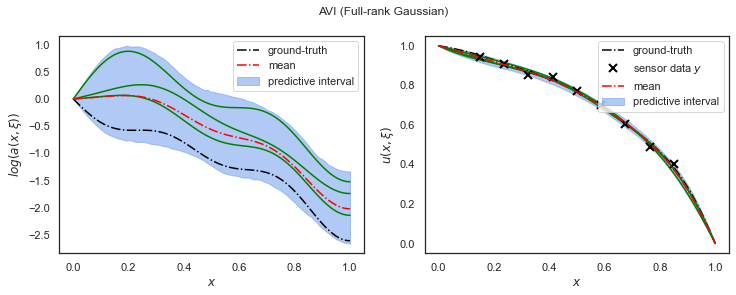

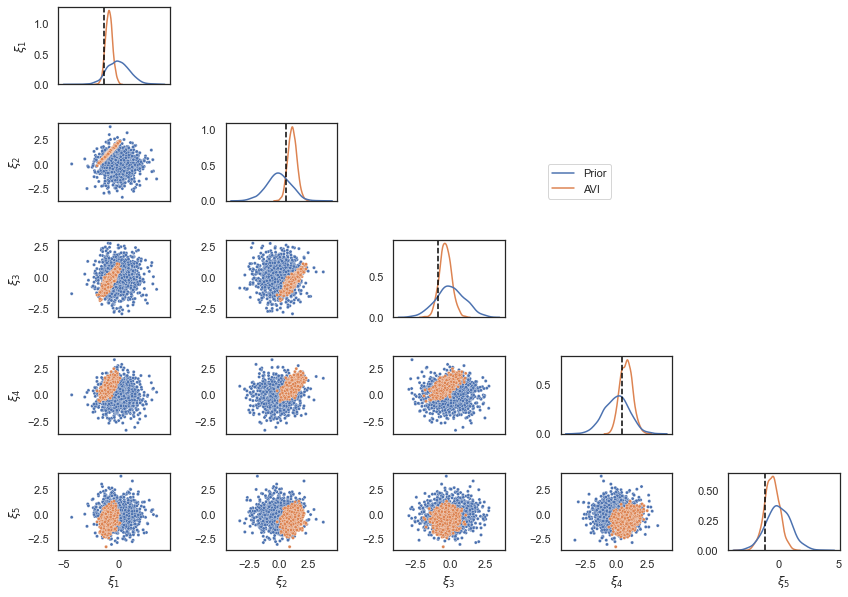

------------------------------------------------------------------------------------------
1
Groundtruth:
 xi_data=[[-0.9210877   0.0022854  -0.74437374 -1.1410705   0.682099  ]],
 y_data=[[0.9332603  0.8364113  0.7811946  0.69324595 0.63682127 0.6047022
  0.4916395  0.3653152  0.18448538]]
Estimated mean:
[-0.7602647   0.19854845 -0.3700279  -1.1397794   1.1161463 ]
Estimated covariance matrix:
[[0.08305044 0.08827682 0.09425277 0.09657669 0.08678012]
 [0.08827682 0.09686328 0.09889624 0.10069212 0.08172448]
 [0.09425277 0.09889624 0.13157625 0.11339063 0.07863721]
 [0.09657669 0.10069212 0.11339063 0.21247861 0.09751361]
 [0.08678012 0.08172448 0.07863721 0.09751361 0.35409528]]


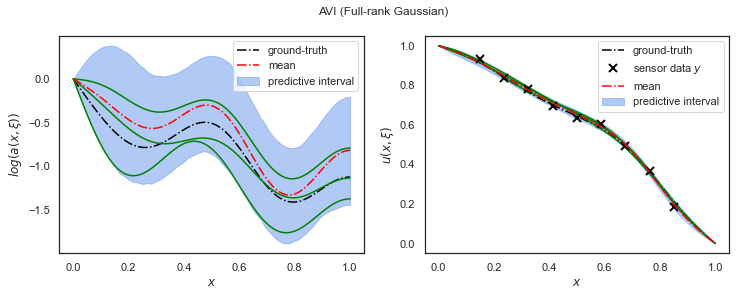

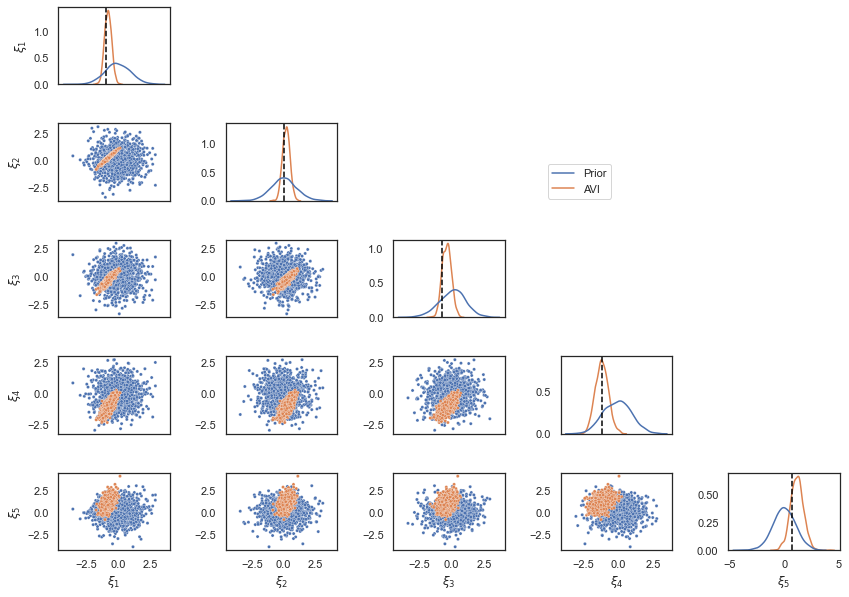

------------------------------------------------------------------------------------------
2
Groundtruth:
 xi_data=[[-1.2560796  -2.455967    0.18935843  0.16297641  1.3519896 ]],
 y_data=[[0.95389193 0.88711494 0.74804926 0.56333745 0.43865386 0.31617194
  0.22327848 0.13826725 0.06044416]]
Estimated mean:
[-1.0669997  -2.133944    0.2858028   0.52480596  1.117331  ]
Estimated covariance matrix:
[[0.10294005 0.10066389 0.11408664 0.09325399 0.10359435]
 [0.10066389 0.10679622 0.10121629 0.10976829 0.08589231]
 [0.11408664 0.10121629 0.16313763 0.06995284 0.14057092]
 [0.09325399 0.10976829 0.06995284 0.217774   0.05641097]
 [0.10359435 0.08589231 0.14057092 0.05641097 0.40612024]]


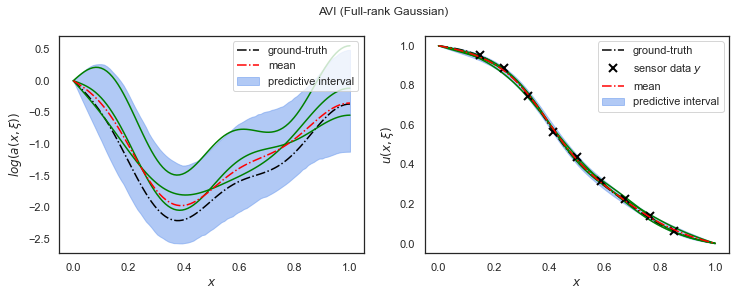

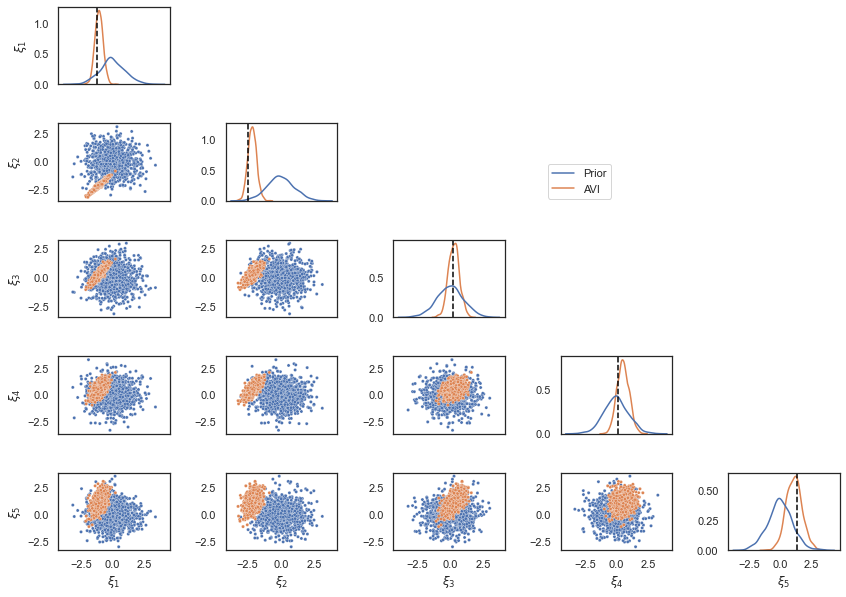

------------------------------------------------------------------------------------------
3
Groundtruth:
 xi_data=[[ 0.3798011   0.04963709  1.343188   -0.6877852   0.7990466 ]],
 y_data=[[0.8098746  0.75047594 0.67045534 0.59575206 0.5473794  0.44568974
  0.32103738 0.20124398 0.09314571]]
Estimated mean:
[ 0.22581525  0.12190075  1.0549177  -1.0315739  -0.07392969]
Estimated covariance matrix:
[[0.06292795 0.06822161 0.08527157 0.08011939 0.09294902]
 [0.06822161 0.08225583 0.08752968 0.09739912 0.07664786]
 [0.08527157 0.08752968 0.13261257 0.0973404  0.12511486]
 [0.08011939 0.09739912 0.0973404  0.20492747 0.06585628]
 [0.09294902 0.07664786 0.12511486 0.06585628 0.3419061 ]]


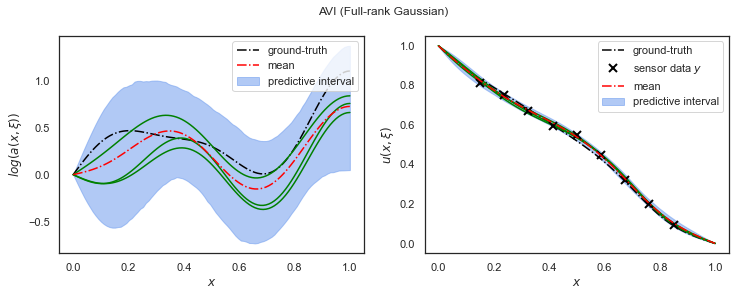

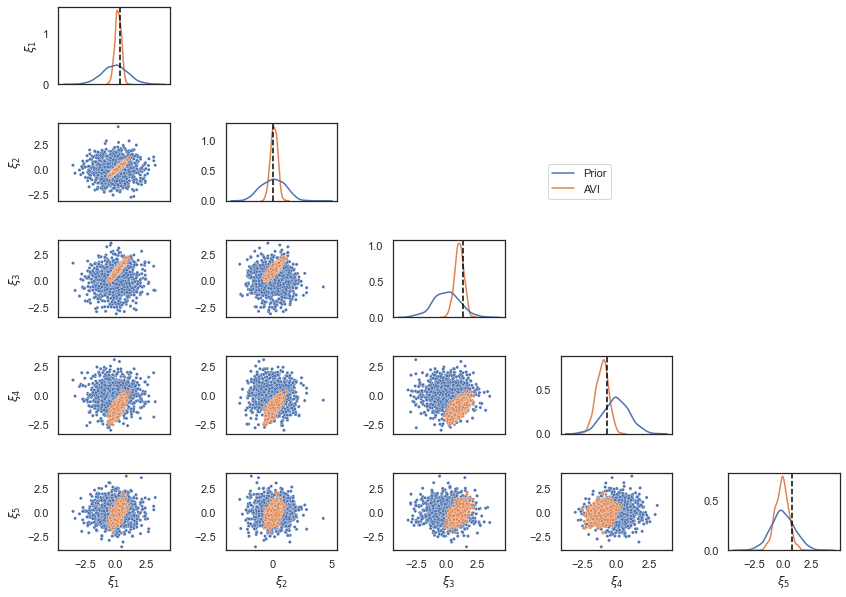

------------------------------------------------------------------------------------------
4
Groundtruth:
 xi_data=[[ 0.9881044  -1.899255   -0.10817211 -0.48783877 -2.031783  ]],
 y_data=[[0.67652506 0.50093406 0.37012723 0.29571316 0.20603429 0.12742722
  0.07969136 0.06034986 0.06551518]]
Estimated mean:
[ 1.5296838  -0.8825631  -0.1219677   0.60898215 -0.6256496 ]
Estimated covariance matrix:
[[ 0.0523486   0.05242614  0.06814083  0.05806204  0.10535292]
 [ 0.05242614  0.08767078  0.0325807   0.08900846  0.12493374]
 [ 0.06814083  0.0325807   0.18494585 -0.03748713  0.1609602 ]
 [ 0.05806204  0.08900846 -0.03748713  0.2997903  -0.06086194]
 [ 0.10535292  0.12493374  0.1609602  -0.06086194  0.550007  ]]


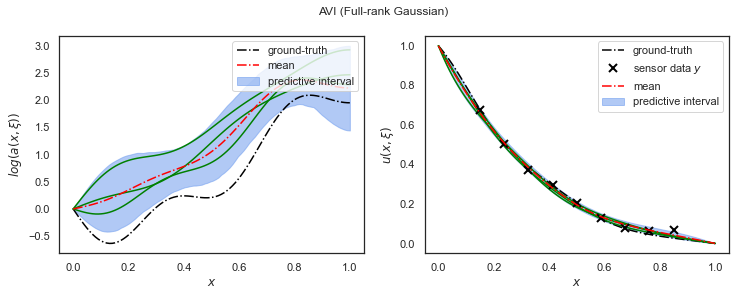

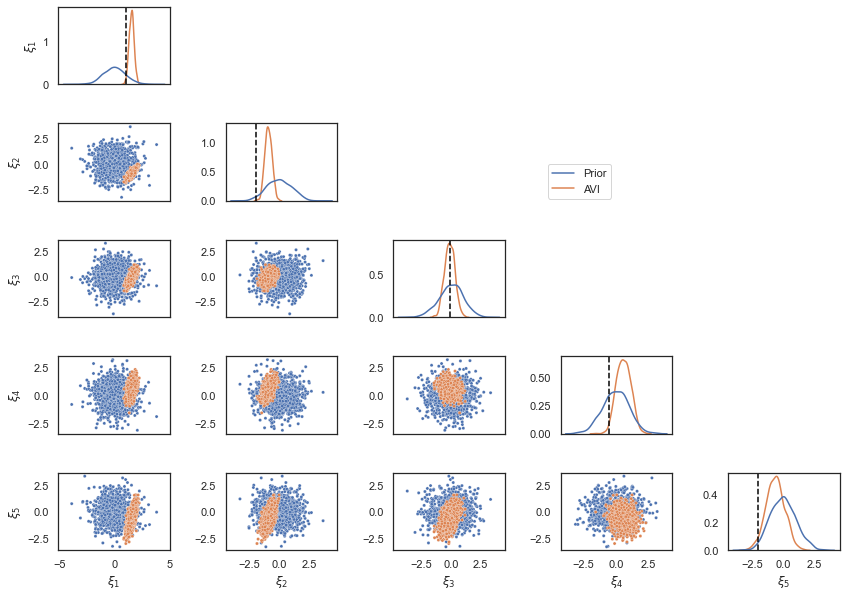

------------------------------------------------------------------------------------------


In [15]:
save = False

n_samples = 1000 # number of posterior samples

for j in range(5):
    print(j)
    
    xi_data, y_data = model.observed_data(n=1)
    print('Groundtruth:\n xi_data='+str(xi_data.data.numpy())+',\n y_data='+str(y_data.data.numpy()))
    
    mean = (model.mu(y_data))[0, :]
    L_diag = model.L_diag(y_data)
    L_offdiag = model.L_offdiag(y_data) #or 0.01*self.L_offdiag(y)
    L = unpack_cholesky(L_diag[0,:], L_offdiag[0,:], model.xi_dim) # L matrix

    print('Estimated mean:\n'+str(mean.data.numpy()))
    print('Estimated covariance matrix:\n'+str(torch.matmul(L,L.T).data.numpy()))
    
    xi_samples_AVI = torch.zeros(n_samples,model.xi_dim)
    for k in range(n_samples):
        zs = torch.randn_like(mean)
        xi_samples_AVI[k] = mean + torch.matmul(L, zs)
    # print(xi_samples_AVI.shape)

    plot(xi_samples_AVI, xi_data, y_data, j, "AVI (Full-rank Gaussian)") 

    ######
    Prior_data = prior_xi_dist.sample([n_samples]).T.data.numpy()
    Prior_dict = dict() 
    for i in range(Prior_data.shape[0]):
        Prior_dict[r'$\xi_{%.0f}$' % (i+1)] = Prior_data[i] 

    AVI_data = xi_samples_AVI.T.data.numpy()
    AVI_dict = dict() 
    for i in range(AVI_data.shape[0]):
        AVI_dict[r'$\xi_{%.0f}$' % (i+1)] = AVI_data[i]   

    df_Prior = pd.DataFrame(Prior_dict)
    df_AVI = pd.DataFrame(AVI_dict)
    df_Prior['Sample type'] = 'Prior'
    df_AVI['Sample type'] = 'AVI'

    df = pd.concat([df_Prior, df_AVI])
    df.reset_index(drop=True, inplace=True)
    pair_plot(df, xi_data, j)
    ######
    print('-'*90)

In [16]:
#list(model.named_parameters())

### Comparison of AVI vs MCMC:

In [17]:
import pyro
import pyro.distributions as dist_pyro
from pyro.infer import MCMC, HMC, NUTS

np.random.seed(37)
torch.manual_seed(37)
pyro.set_rng_seed(37)

In [18]:
save=True

results_dir = os.path.join(os.getcwd(), 'results/')
if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

In [19]:
xi_data_, y_data_ = model.observed_data(n=20)
print(xi_data_.shape, y_data_.shape)
print('Groundtruth:\n xi_data='+str(xi_data_.data.numpy())+',\n y_data='+str(y_data_.data.numpy()))

torch.save(xi_data_, results_dir +'xi_data.pt')
torch.save(y_data_, results_dir +'y_data.pt')

torch.Size([20, 5]) torch.Size([20, 9])
Groundtruth:
 xi_data=[[-0.09384752 -0.49599066  0.9621382   0.3939917  -0.92998105]
 [ 1.185468    1.4125743   0.16325866 -1.7672827  -1.3445061 ]
 [ 1.5448754   0.45562586  0.11739626 -0.7239963  -2.1713018 ]
 [ 0.7871151  -0.62889576 -0.04413708 -1.2322628  -0.5069863 ]
 [-1.3766444  -2.0966082  -1.0177851   0.37341422 -0.13289762]
 [ 0.05863146 -1.6333108   0.6669979  -1.8708996   0.16858663]
 [ 0.9331735   0.20100449  0.9667146   0.22768925 -1.7471474 ]
 [ 2.5882704   1.0853857   0.04483174 -1.4370277   1.3024021 ]
 [ 0.8505033   1.0503205  -0.13052183 -0.5962936  -0.2837806 ]
 [-0.7701383   1.5392127   0.03044852  0.5329035   0.5738441 ]
 [ 0.93549037  0.1636075  -0.73672336  1.3143641   0.95261484]
 [ 0.4499938  -1.3973818  -0.51734835  0.29636776 -0.6820383 ]
 [ 0.11490524  1.1775166  -0.6189497  -0.5095518   1.1651816 ]
 [-1.9670703   0.9064985   0.80727345 -0.44357055  0.8257656 ]
 [-0.27047768 -0.59012616 -0.7448506  -0.5212244  -0.666

0
Groundtruth:
 xi_data=[[-0.09384752 -0.49599066  0.9621382   0.3939917  -0.92998105]],
 y_data=[[0.87490743 0.7926272  0.7375075  0.614052   0.52683306 0.3926466
  0.2770636  0.16707356 0.13186327]]
0_AVI
Estimated mean:
[-0.08514147 -0.36768454  0.87921715  0.42128426 -0.46109098]
Estimated covariance matrix:
[[0.07917405 0.08900902 0.09944756 0.09419673 0.0980436 ]
 [0.08900902 0.10644281 0.10746385 0.11714552 0.09329591]
 [0.09944756 0.10746385 0.14541556 0.10558027 0.12881689]
 [0.09419673 0.11714552 0.10558027 0.22221315 0.07223745]
 [0.0980436  0.09329591 0.12881689 0.07223745 0.34893635]]
torch.Size([1000, 5])


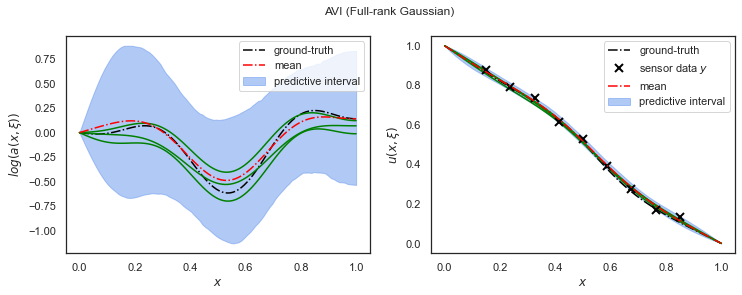

------------------------------------------------------------------------------------------
0_MCMC


Sample: 100%|██████████| 3300/3300 [02:33, 21.55it/s, step size=9.70e-02, acc. prob=0.933]


torch.Size([1000, 5])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]     -0.27      0.31     -0.26     -0.78      0.23    558.20      1.01
  input[1]     -0.60      0.35     -0.60     -1.19     -0.03    577.34      1.01
  input[2]      0.74      0.42      0.73      0.03      1.37    602.28      1.00
  input[3]      0.26      0.50      0.25     -0.51      1.08    781.70      1.00
  input[4]     -0.71      0.66     -0.71     -1.86      0.28    797.36      1.01

Number of divergences: 0
None


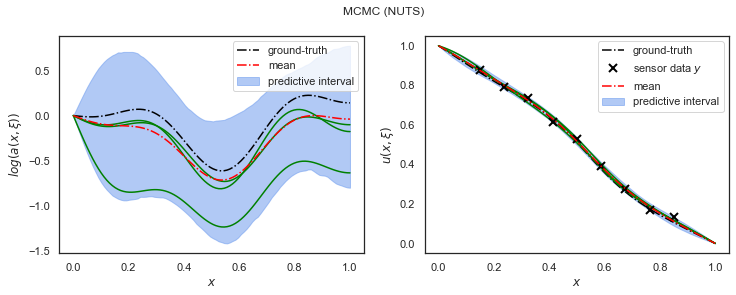

------------------------------------------------------------------------------------------


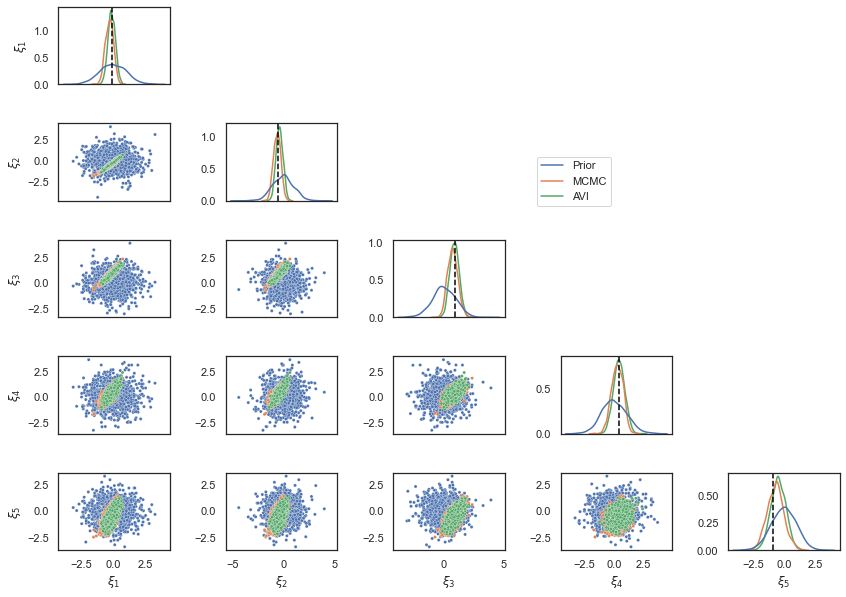

*****************************************************************************************************************************************************************************************
1
Groundtruth:
 xi_data=[[ 1.185468    1.4125743   0.16325866 -1.7672827  -1.3445061 ]],
 y_data=[[0.6179939  0.48710236 0.44695854 0.4260288  0.40434894 0.32878044
  0.29350793 0.19844048 0.10305757]]
1_AVI
Estimated mean:
[ 1.3025491   1.3602031   0.29336077 -1.4981266  -0.5052362 ]
Estimated covariance matrix:
[[0.03618944 0.03586745 0.04502951 0.06143987 0.09265081]
 [0.03586745 0.04628647 0.04078555 0.05041363 0.08360828]
 [0.04502951 0.04078555 0.10714997 0.05015292 0.08182612]
 [0.06143987 0.05041363 0.05015292 0.27386892 0.04896741]
 [0.09265081 0.08360828 0.08182612 0.04896741 0.46820796]]
torch.Size([1000, 5])


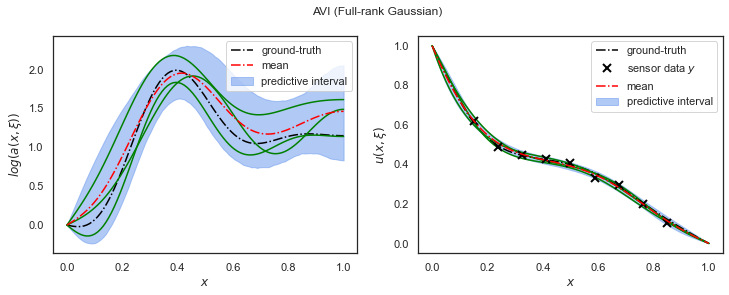

------------------------------------------------------------------------------------------
1_MCMC


Sample: 100%|██████████| 3300/3300 [03:11, 17.21it/s, step size=8.99e-02, acc. prob=0.955]


torch.Size([1000, 5])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]      1.34      0.21      1.34      0.96      1.66    513.43      1.00
  input[1]      1.41      0.23      1.41      1.03      1.77    592.64      1.00
  input[2]      0.37      0.36      0.37     -0.16      0.98    655.56      1.00
  input[3]     -1.49      0.57     -1.49     -2.37     -0.53   1052.25      1.00
  input[4]     -0.59      0.74     -0.61     -1.82      0.61    803.85      1.00

Number of divergences: 0
None


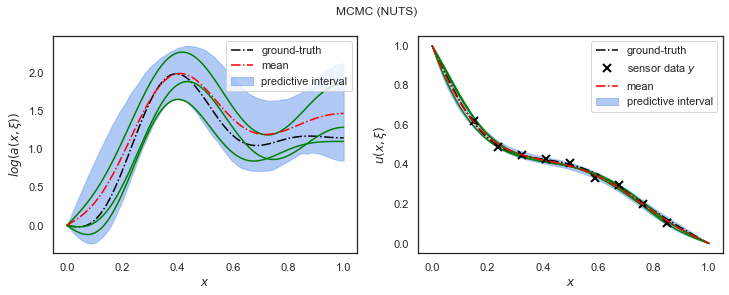

------------------------------------------------------------------------------------------


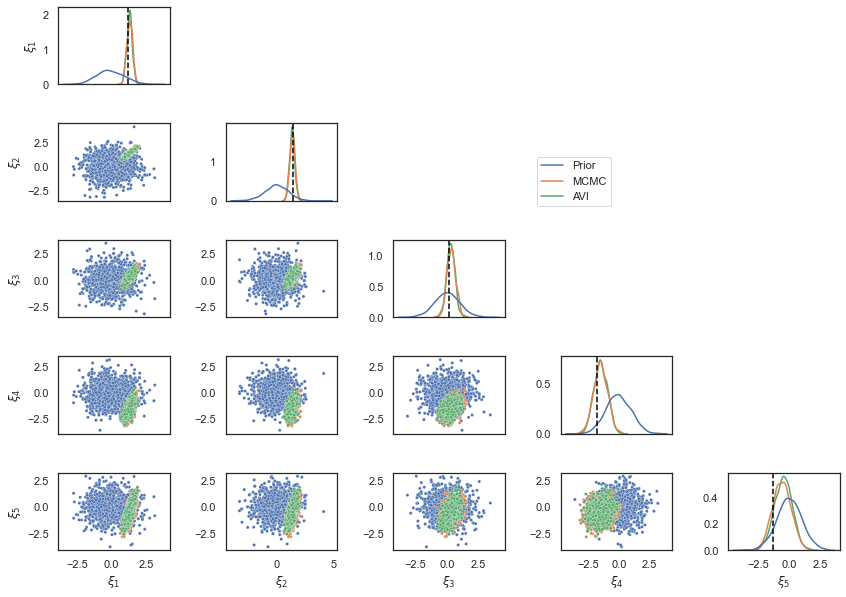

*****************************************************************************************************************************************************************************************
2
Groundtruth:
 xi_data=[[ 1.5448754   0.45562586  0.11739626 -0.7239963  -2.1713018 ]],
 y_data=[[0.55384856 0.42030534 0.34546116 0.29151902 0.2956249  0.22150552
  0.14227906 0.08644436 0.08164779]]
2_AVI
Estimated mean:
[ 1.7580149   0.5561487   0.59906983 -0.7751015  -1.0108577 ]
Estimated covariance matrix:
[[ 3.4414120e-02  3.2430757e-02  4.5646925e-02  5.0906293e-02
   9.5936358e-02]
 [ 3.2430757e-02  4.9365260e-02  2.8506335e-02  5.7236053e-02
   8.5320733e-02]
 [ 4.5646925e-02  2.8506335e-02  1.3035390e-01  2.2022653e-04
   1.1987662e-01]
 [ 5.0906293e-02  5.7236053e-02  2.2022653e-04  2.7298376e-01
  -9.1272853e-03]
 [ 9.5936358e-02  8.5320733e-02  1.1987662e-01 -9.1272853e-03
   5.3134483e-01]]
torch.Size([1000, 5])


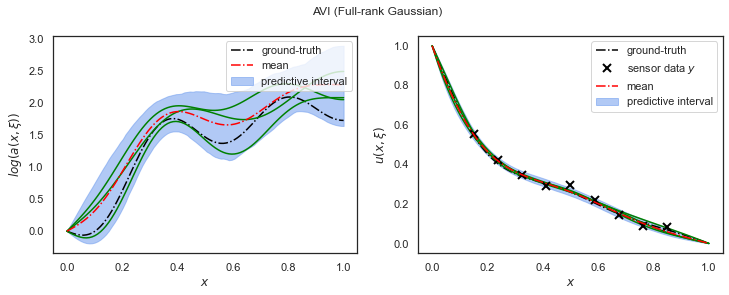

------------------------------------------------------------------------------------------
2_MCMC


Sample: 100%|██████████| 3300/3300 [02:29, 22.09it/s, step size=1.14e-01, acc. prob=0.920]


torch.Size([1000, 5])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]      1.64      0.21      1.65      1.30      1.97    827.74      1.00
  input[1]      0.51      0.22      0.51      0.16      0.89   1049.78      1.00
  input[2]      0.49      0.38      0.49     -0.13      1.11   1255.88      1.00
  input[3]     -0.99      0.56     -0.99     -1.89     -0.05    937.86      1.00
  input[4]     -1.31      0.75     -1.32     -2.50     -0.05   1124.39      1.00

Number of divergences: 0
None


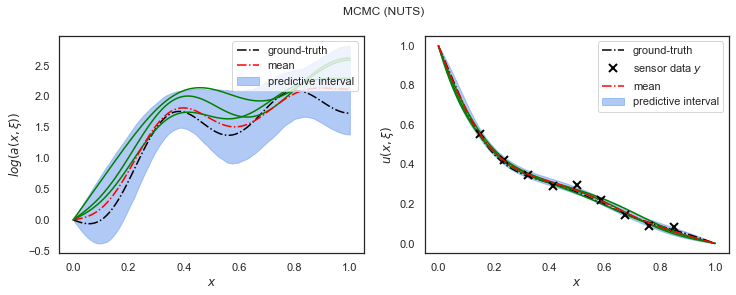

------------------------------------------------------------------------------------------


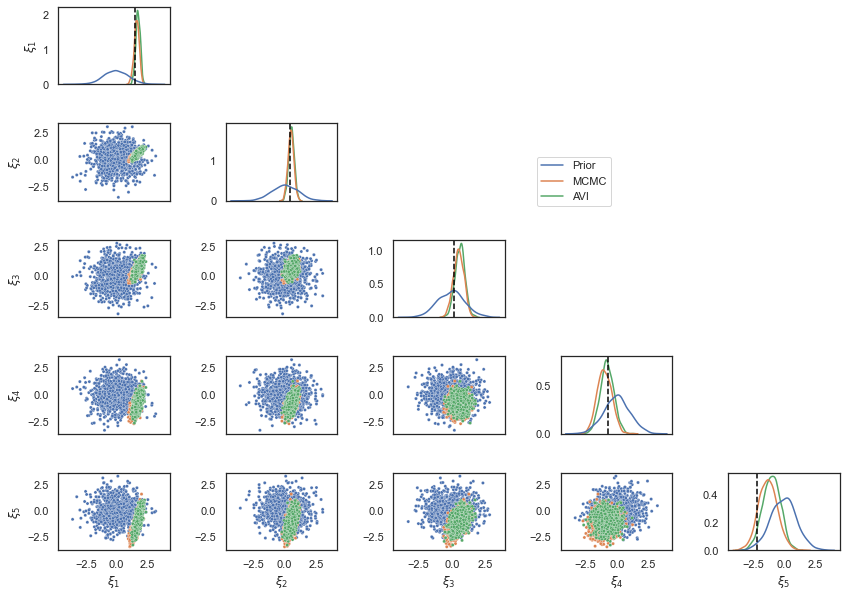

*****************************************************************************************************************************************************************************************
3
Groundtruth:
 xi_data=[[ 0.7871151  -0.62889576 -0.04413708 -1.2322628  -0.5069863 ]],
 y_data=[[0.71989065 0.5569394  0.44218782 0.35274988 0.30009675 0.25938812
  0.18275385 0.09737056 0.04751953]]
3_AVI
Estimated mean:
[ 0.94485664 -0.4672916   0.08642879 -1.3379964   0.51768386]
Estimated covariance matrix:
[[0.04830326 0.04923773 0.06137169 0.04963138 0.09403739]
 [0.04923773 0.06563056 0.043635   0.06910276 0.09266073]
 [0.06137169 0.043635   0.12896672 0.000845   0.11448529]
 [0.04963138 0.06910276 0.000845   0.22482741 0.012094  ]
 [0.09403739 0.09266073 0.11448529 0.012094   0.37417722]]
torch.Size([1000, 5])


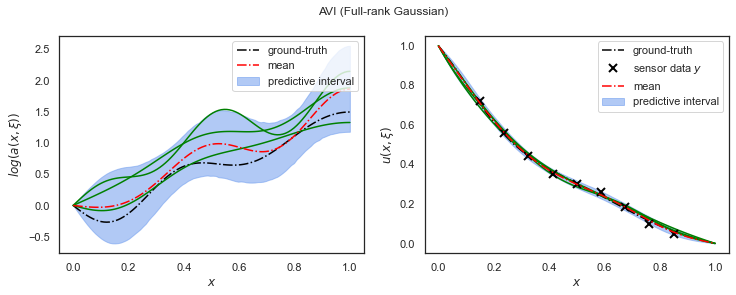

------------------------------------------------------------------------------------------
3_MCMC


Sample: 100%|██████████| 3300/3300 [02:47, 19.74it/s, step size=1.31e-01, acc. prob=0.943]


torch.Size([1000, 5])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]      0.83      0.24      0.82      0.43      1.23    876.04      1.00
  input[1]     -0.69      0.28     -0.69     -1.13     -0.24    924.73      1.00
  input[2]      0.09      0.38      0.08     -0.56      0.66   1205.44      1.00
  input[3]     -1.66      0.52     -1.67     -2.53     -0.82   1032.54      1.00
  input[4]      0.29      0.70      0.30     -0.86      1.46   1098.12      1.00

Number of divergences: 0
None


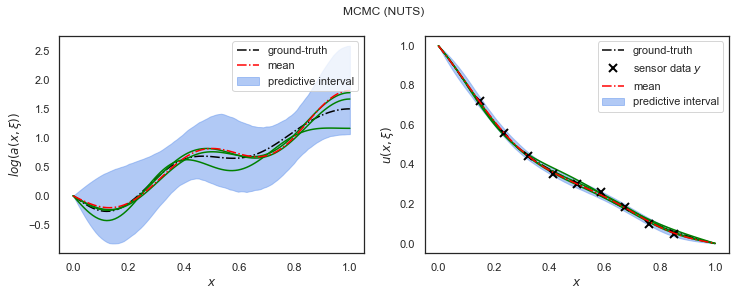

------------------------------------------------------------------------------------------


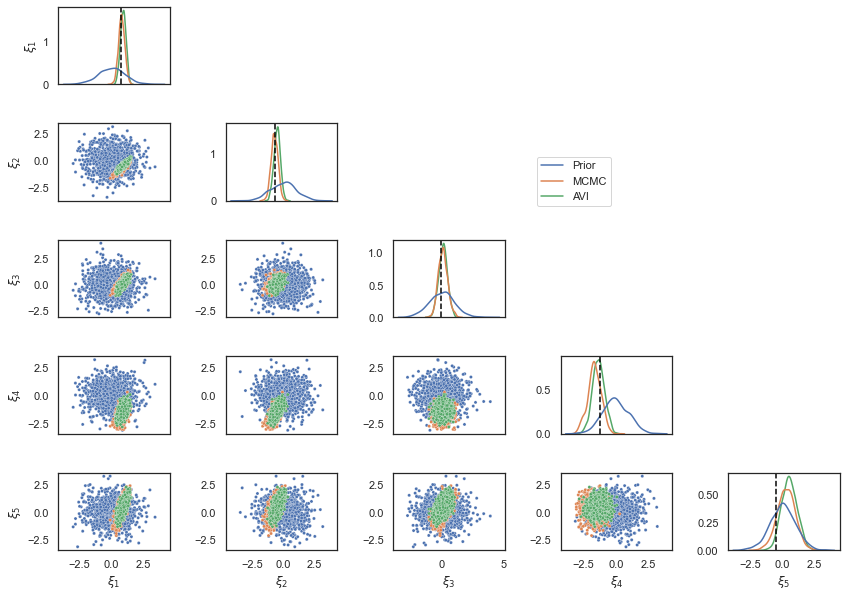

*****************************************************************************************************************************************************************************************
4
Groundtruth:
 xi_data=[[-1.3766444  -2.0966082  -1.0177851   0.37341422 -0.13289762]],
 y_data=[[0.94163257 0.8399468  0.7108488  0.5643407  0.42245245 0.33646575
  0.23524027 0.16946945 0.11484168]]
4_AVI
Estimated mean:
[-0.7759633  -1.528005   -0.28250676  0.9293682   0.7154384 ]
Estimated covariance matrix:
[[0.09452151 0.09612288 0.10102446 0.08948813 0.10178865]
 [0.09612288 0.10279375 0.09516671 0.10021394 0.10067756]
 [0.10102446 0.09516671 0.14247215 0.06179562 0.12436127]
 [0.08948813 0.10021394 0.06179562 0.20623967 0.04418992]
 [0.10178865 0.10067756 0.12436127 0.04418992 0.4013782 ]]
torch.Size([1000, 5])


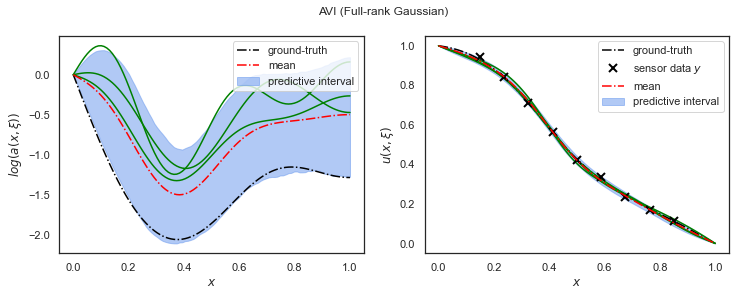

------------------------------------------------------------------------------------------
4_MCMC


Sample: 100%|██████████| 3300/3300 [03:09, 17.42it/s, step size=8.89e-02, acc. prob=0.946]


torch.Size([1000, 5])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]     -0.96      0.36     -0.92     -1.50     -0.30    654.58      1.00
  input[1]     -1.69      0.38     -1.67     -2.31     -1.06    669.57      1.00
  input[2]     -0.47      0.42     -0.46     -1.21      0.18    748.82      1.00
  input[3]      0.64      0.51      0.65     -0.21      1.46    948.27      1.00
  input[4]      0.51      0.63      0.52     -0.51      1.54   1044.01      1.00

Number of divergences: 0
None


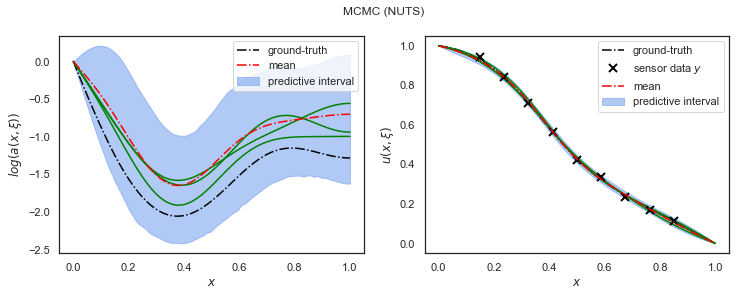

------------------------------------------------------------------------------------------


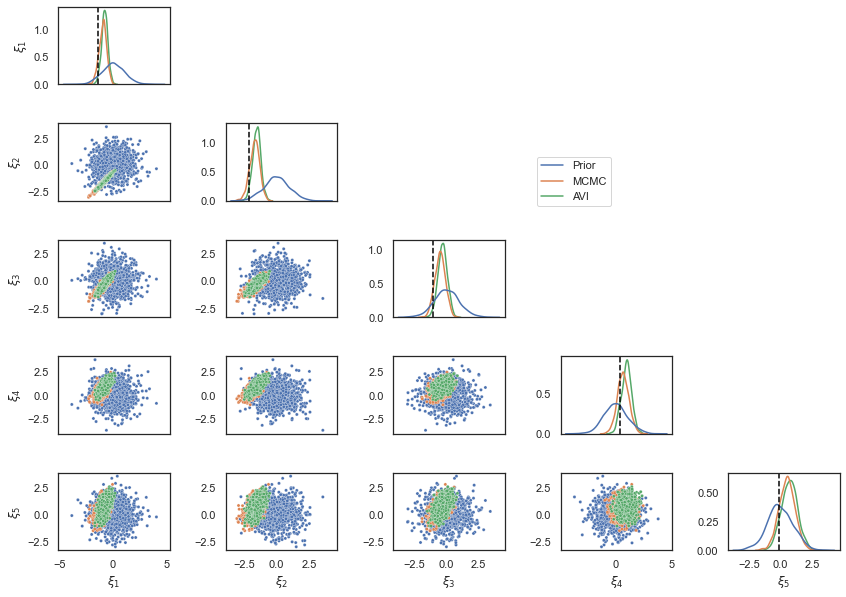

*****************************************************************************************************************************************************************************************
5
Groundtruth:
 xi_data=[[ 0.05863146 -1.6333108   0.6669979  -1.8708996   0.16858663]],
 y_data=[[0.83009845 0.7019589  0.5576934  0.49712297 0.39005587 0.2828126
  0.17453614 0.10809775 0.02583709]]
5_AVI
Estimated mean:
[ 0.42996365 -1.1153877   1.1105182  -0.79248816  0.2205573 ]
Estimated covariance matrix:
[[0.06640799 0.06926611 0.08967569 0.07163163 0.1051928 ]
 [0.06926611 0.08969243 0.07681295 0.10418066 0.08249874]
 [0.08967569 0.07681295 0.1525941  0.05302103 0.1566796 ]
 [0.07163163 0.10418066 0.05302103 0.21580052 0.04069598]
 [0.1051928  0.08249874 0.1566796  0.04069598 0.366225  ]]
torch.Size([1000, 5])


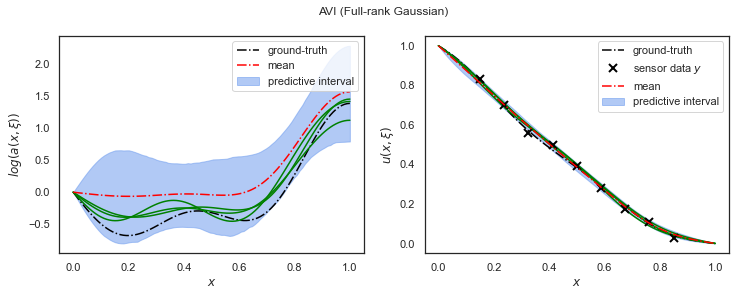

------------------------------------------------------------------------------------------
5_MCMC


Sample: 100%|██████████| 3300/3300 [02:45, 19.91it/s, step size=1.15e-01, acc. prob=0.940]


torch.Size([1000, 5])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]      0.07      0.28      0.08     -0.41      0.49    696.55      1.00
  input[1]     -1.55      0.30     -1.55     -2.02     -1.06    767.55      1.00
  input[2]      0.67      0.40      0.67     -0.00      1.30    827.90      1.00
  input[3]     -1.36      0.49     -1.36     -2.11     -0.50   1042.78      1.00
  input[4]     -0.26      0.61     -0.25     -1.30      0.71    935.59      1.00

Number of divergences: 0
None


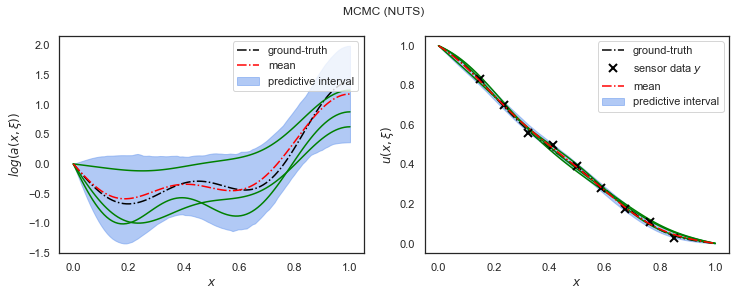

------------------------------------------------------------------------------------------


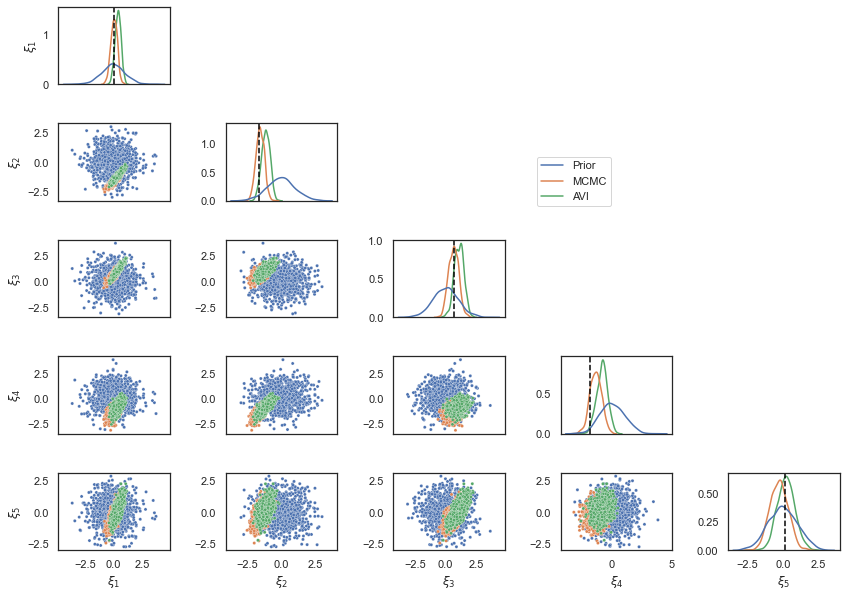

*****************************************************************************************************************************************************************************************
6
Groundtruth:
 xi_data=[[ 0.9331735   0.20100449  0.9667146   0.22768925 -1.7471474 ]],
 y_data=[[0.71701276 0.6406426  0.54235864 0.4658263  0.39969537 0.2943925
  0.21006526 0.13015142 0.09754755]]
6_AVI
Estimated mean:
[ 0.92043793  0.06388716  0.8516319   0.02175409 -0.8632091 ]
Estimated covariance matrix:
[[0.05488252 0.06035131 0.07503982 0.07336602 0.10513584]
 [0.06035131 0.07541446 0.07471466 0.09347227 0.10383282]
 [0.07503982 0.07471466 0.13349663 0.06171409 0.14299598]
 [0.07336602 0.09347227 0.06171409 0.2364256  0.04307065]
 [0.10513584 0.10383282 0.14299598 0.04307065 0.43145132]]
torch.Size([1000, 5])


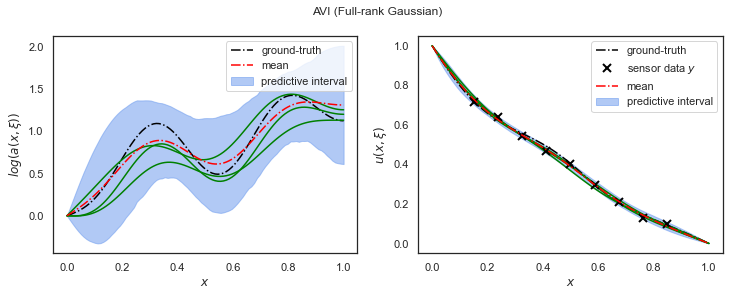

------------------------------------------------------------------------------------------
6_MCMC


Sample: 100%|██████████| 3300/3300 [02:12, 24.96it/s, step size=1.63e-01, acc. prob=0.927]


torch.Size([1000, 5])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]      0.97      0.24      0.98      0.59      1.37    663.09      1.00
  input[1]      0.10      0.28      0.11     -0.36      0.57    727.73      1.00
  input[2]      0.91      0.39      0.91      0.31      1.59    817.40      1.00
  input[3]      0.07      0.52      0.06     -0.80      0.88   1025.20      1.00
  input[4]     -0.69      0.70     -0.68     -1.81      0.50   1089.05      1.00

Number of divergences: 0
None


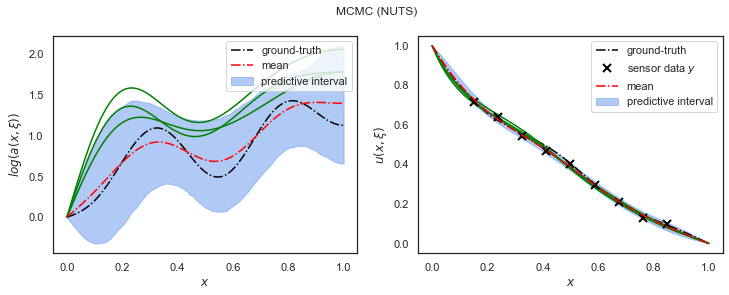

------------------------------------------------------------------------------------------


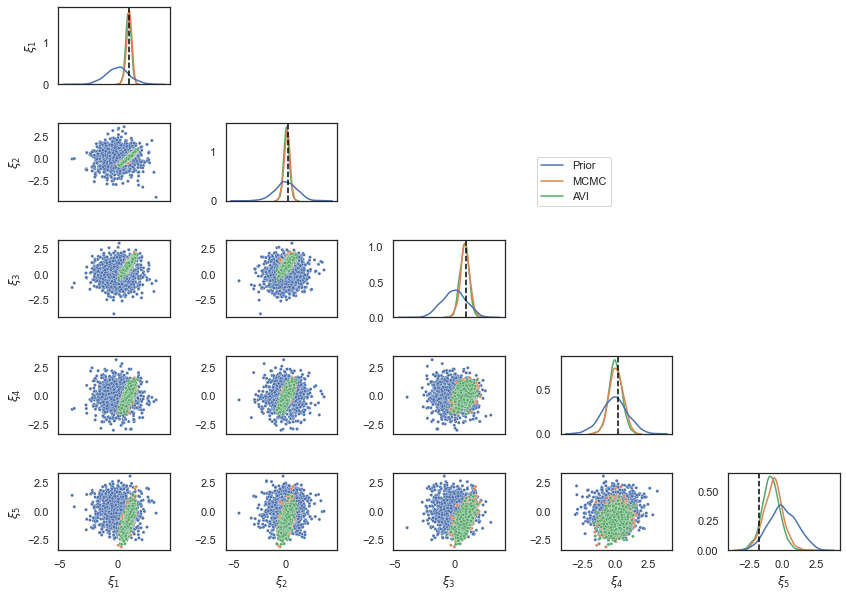

*****************************************************************************************************************************************************************************************
7
Groundtruth:
 xi_data=[[ 2.5882704   1.0853857   0.04483174 -1.4370277   1.3024021 ]],
 y_data=[[0.4060634  0.2819952  0.2147279  0.18058224 0.15682402 0.1408691
  0.11854064 0.08464767 0.00139987]]
7_AVI
Estimated mean:
[ 2.279262    0.66116     0.37582263 -1.8975288  -0.6361662 ]
Estimated covariance matrix:
[[ 0.03457386  0.02217303  0.04398526  0.03830111  0.10064609]
 [ 0.02217303  0.05601025 -0.01178662  0.05862525  0.06099411]
 [ 0.04398526 -0.01178662  0.18579045 -0.08252291  0.14503   ]
 [ 0.03830111  0.05862525 -0.08252291  0.33854684 -0.09092637]
 [ 0.10064609  0.06099411  0.14503    -0.09092637  0.5747603 ]]
torch.Size([1000, 5])


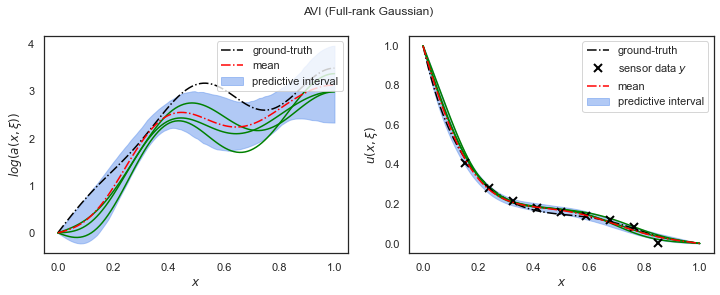

------------------------------------------------------------------------------------------
7_MCMC


Sample: 100%|██████████| 3300/3300 [01:54, 28.85it/s, step size=1.91e-01, acc. prob=0.923]


torch.Size([1000, 5])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]      2.57      0.16      2.58      2.30      2.82    868.63      1.00
  input[1]      1.01      0.24      1.01      0.65      1.42   1208.60      1.00
  input[2]      0.56      0.42      0.56     -0.13      1.21   1153.22      1.00
  input[3]     -1.18      0.66     -1.18     -2.17     -0.06   1823.51      1.00
  input[4]      0.16      0.77      0.16     -1.16      1.36   1005.20      1.00

Number of divergences: 0
None


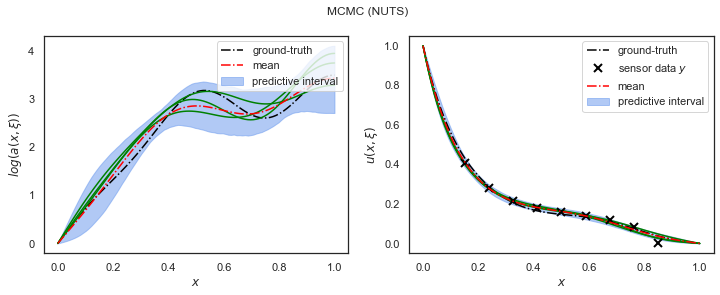

------------------------------------------------------------------------------------------


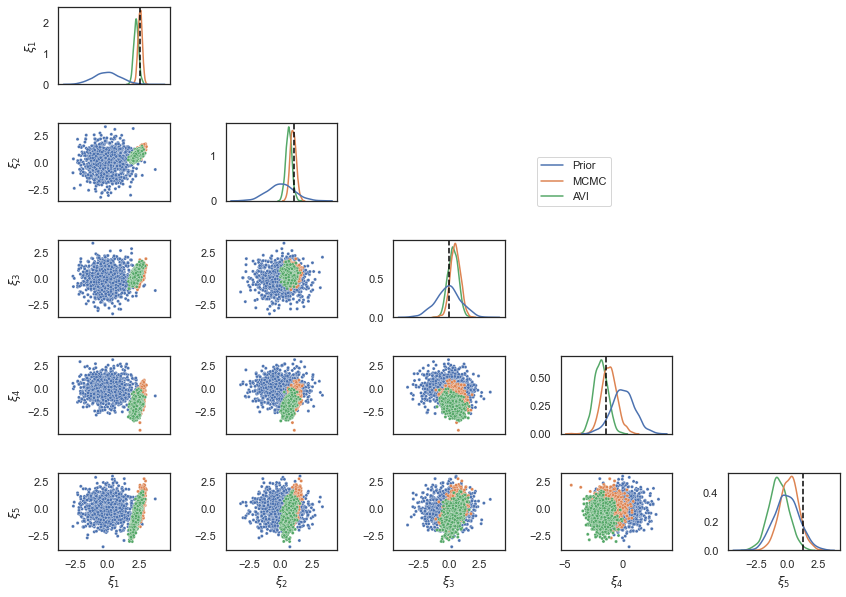

*****************************************************************************************************************************************************************************************
8
Groundtruth:
 xi_data=[[ 0.8505033   1.0503205  -0.13052183 -0.5962936  -0.2837806 ]],
 y_data=[[0.72427905 0.6008789  0.5519526  0.4982316  0.44495183 0.4078458
  0.33451387 0.21726519 0.15672491]]
8_AVI
Estimated mean:
[ 0.80006266  0.9626865  -0.06135137 -0.90448177 -0.21073532]
Estimated covariance matrix:
[[0.04689833 0.04990264 0.05674088 0.07215568 0.09511609]
 [0.04990264 0.05943787 0.05774356 0.06742419 0.09623756]
 [0.05674088 0.05774356 0.103884   0.07058309 0.08528134]
 [0.07215568 0.06742419 0.07058309 0.2471866  0.06706811]
 [0.09511609 0.09623756 0.08528134 0.06706811 0.4174962 ]]
torch.Size([1000, 5])


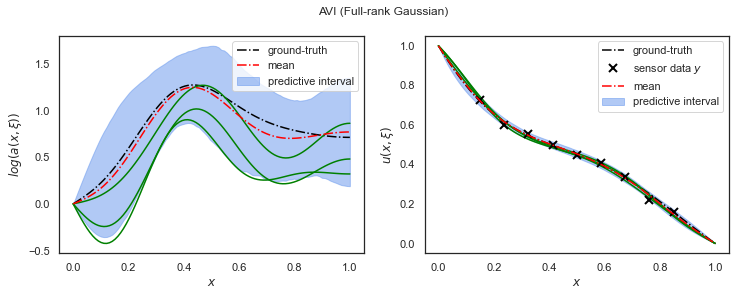

------------------------------------------------------------------------------------------
8_MCMC


Sample: 100%|██████████| 3300/3300 [03:07, 17.57it/s, step size=1.13e-01, acc. prob=0.951]


torch.Size([1000, 5])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]      0.75      0.23      0.76      0.37      1.12    635.36      1.00
  input[1]      0.89      0.26      0.90      0.50      1.34    680.17      1.00
  input[2]     -0.05      0.34     -0.05     -0.62      0.51    840.25      1.00
  input[3]     -0.96      0.53     -0.96     -1.83     -0.12    892.55      1.00
  input[4]     -0.50      0.70     -0.50     -1.65      0.61   1181.75      1.00

Number of divergences: 0
None


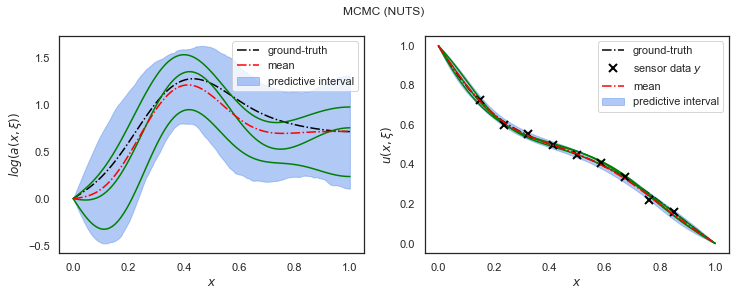

------------------------------------------------------------------------------------------


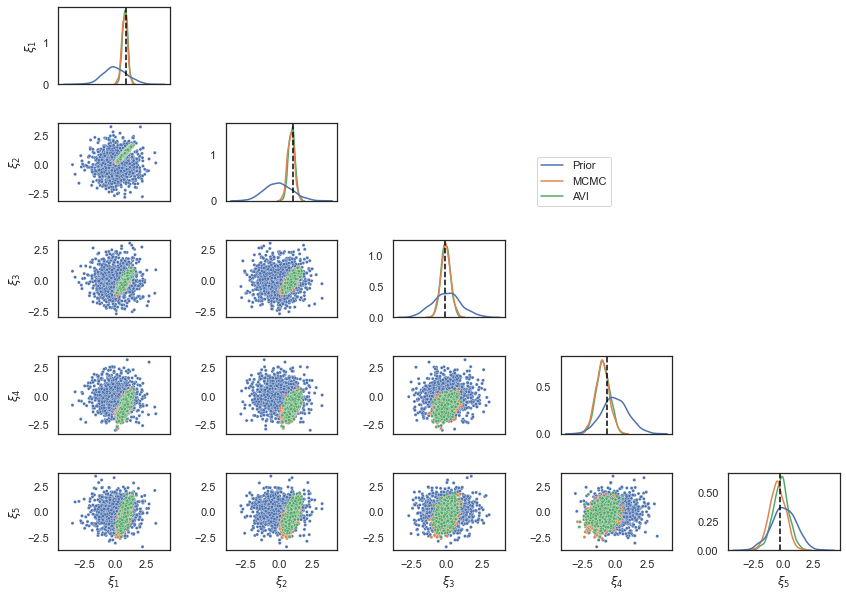

*****************************************************************************************************************************************************************************************
9
Groundtruth:
 xi_data=[[-0.7701383   1.5392127   0.03044852  0.5329035   0.5738441 ]],
 y_data=[[0.96356034 0.92440265 0.8868768  0.84074473 0.81935394 0.74075836
  0.65002877 0.5198854  0.34817848]]
9_AVI
Estimated mean:
[-1.2084305   1.0744197  -0.3258893  -0.18365185  0.23215848]
Estimated covariance matrix:
[[0.11176542 0.12610249 0.11952429 0.09804815 0.0495129 ]
 [0.12610249 0.14682367 0.14169362 0.1092038  0.04550389]
 [0.11952429 0.14169362 0.17422622 0.14596064 0.02364828]
 [0.09804815 0.1092038  0.14596064 0.24810472 0.10428485]
 [0.0495129  0.04550389 0.02364828 0.10428485 0.3928365 ]]
torch.Size([1000, 5])


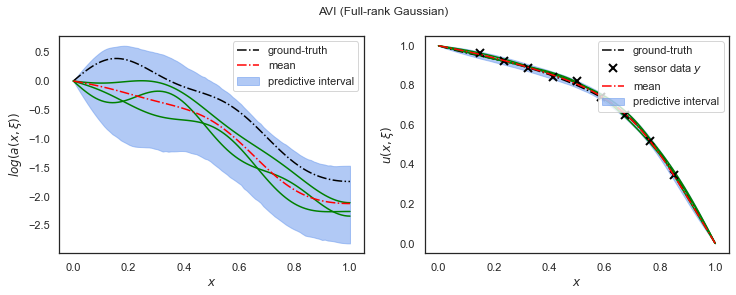

------------------------------------------------------------------------------------------
9_MCMC


Sample: 100%|██████████| 3300/3300 [03:23, 16.21it/s, step size=1.01e-01, acc. prob=0.950]


torch.Size([1000, 5])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]     -1.30      0.39     -1.29     -1.93     -0.69    660.04      1.00
  input[1]      0.96      0.44      0.97      0.21      1.64    665.14      1.00
  input[2]     -0.42      0.49     -0.43     -1.22      0.36    569.19      1.00
  input[3]     -0.24      0.61     -0.23     -1.22      0.77    685.86      1.00
  input[4]      0.07      0.67      0.07     -0.97      1.23   1071.67      1.00

Number of divergences: 0
None


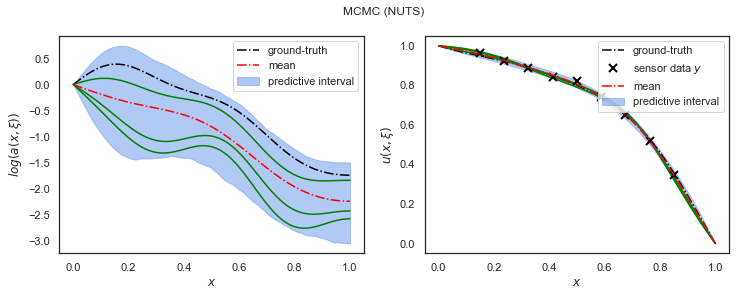

------------------------------------------------------------------------------------------


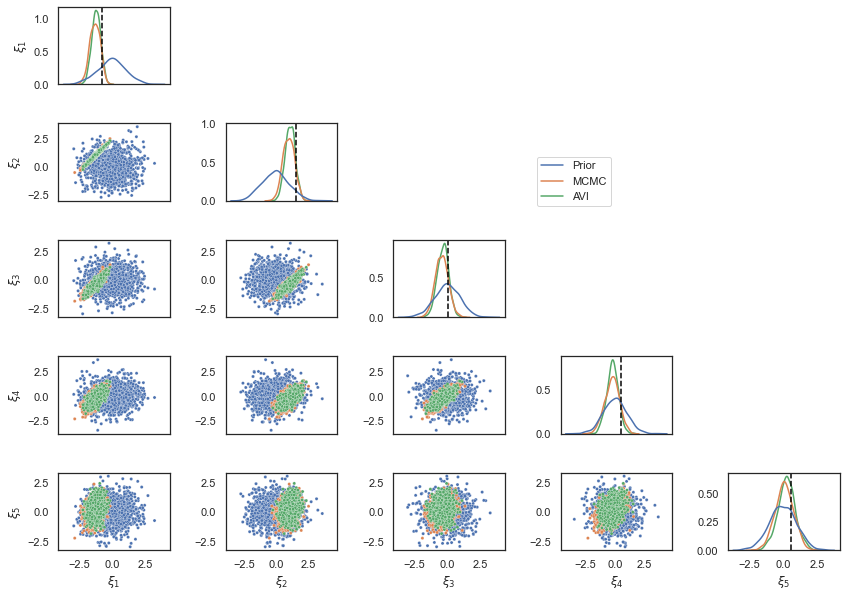

*****************************************************************************************************************************************************************************************
10
Groundtruth:
 xi_data=[[ 0.93549037  0.1636075  -0.73672336  1.3143641   0.95261484]],
 y_data=[[0.751338   0.67081386 0.56066793 0.4332733  0.3120523  0.24739106
  0.2303582  0.19827786 0.14791246]]
10_AVI
Estimated mean:
[ 0.5551126  -0.26644427 -1.2300924   1.5779492  -0.5593828 ]
Estimated covariance matrix:
[[ 0.06422568  0.06960115  0.06388316  0.08298371  0.10465981]
 [ 0.06960115  0.08164465  0.06347485  0.08204362  0.12894793]
 [ 0.06388316  0.06347485  0.11631171  0.03924275  0.1152747 ]
 [ 0.08298371  0.08204362  0.03924275  0.25658628 -0.03371892]
 [ 0.10465981  0.12894793  0.1152747  -0.03371892  0.5395474 ]]
torch.Size([1000, 5])


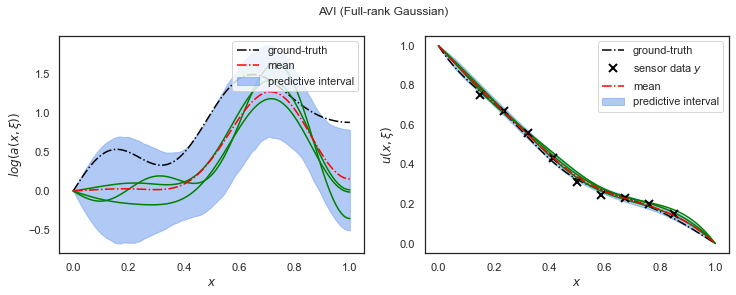

------------------------------------------------------------------------------------------
10_MCMC


Sample: 100%|██████████| 3300/3300 [02:30, 21.94it/s, step size=1.43e-01, acc. prob=0.948]


torch.Size([1000, 5])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]      1.09      0.23      1.10      0.70      1.46    827.79      1.00
  input[1]      0.28      0.28      0.28     -0.21      0.71    858.56      1.00
  input[2]     -0.72      0.41     -0.71     -1.34     -0.01    941.36      1.00
  input[3]      2.34      0.56      2.33      1.34      3.18   1332.20      1.00
  input[4]      0.41      0.78      0.39     -0.83      1.72   1316.12      1.00

Number of divergences: 0
None


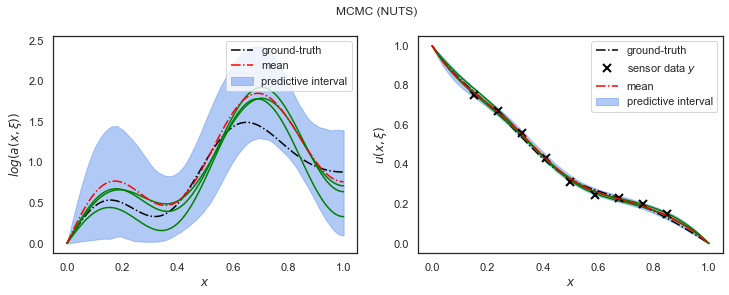

------------------------------------------------------------------------------------------


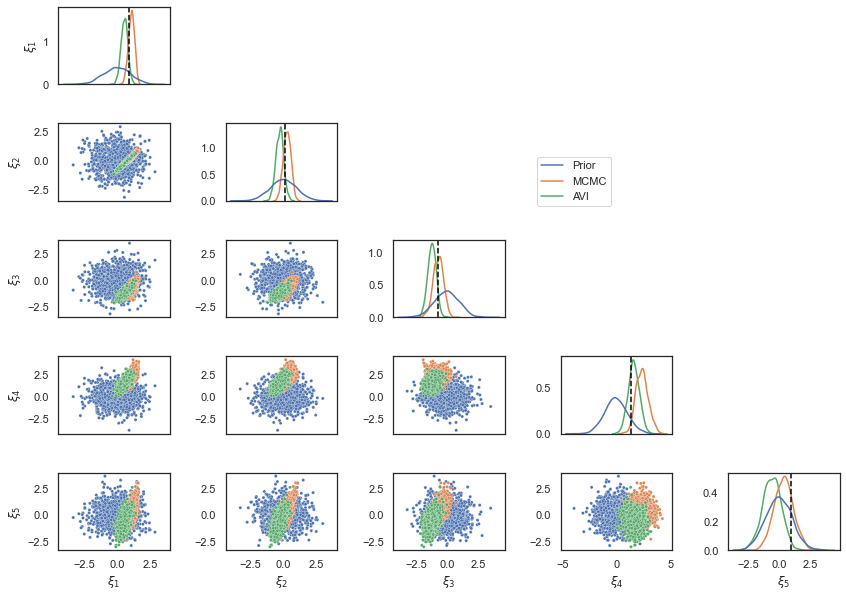

*****************************************************************************************************************************************************************************************
11
Groundtruth:
 xi_data=[[ 0.4499938  -1.3973818  -0.51734835  0.29636776 -0.6820383 ]],
 y_data=[[0.7737652  0.6496034  0.48081788 0.3711717  0.29878244 0.19876975
  0.136425   0.09877858 0.06010424]]
11_AVI
Estimated mean:
[ 0.70562625 -1.1349951  -0.07104273  0.05295974  0.16442752]
Estimated covariance matrix:
[[ 0.06325557  0.06509035  0.0797004   0.06326128  0.10413368]
 [ 0.06509035  0.08434083  0.05912463  0.08838998  0.11119913]
 [ 0.0797004   0.05912463  0.16215803  0.00177308  0.14058562]
 [ 0.06326128  0.08838998  0.00177308  0.246417   -0.00325165]
 [ 0.10413368  0.11119913  0.14058562 -0.00325165  0.4107853 ]]
torch.Size([1000, 5])


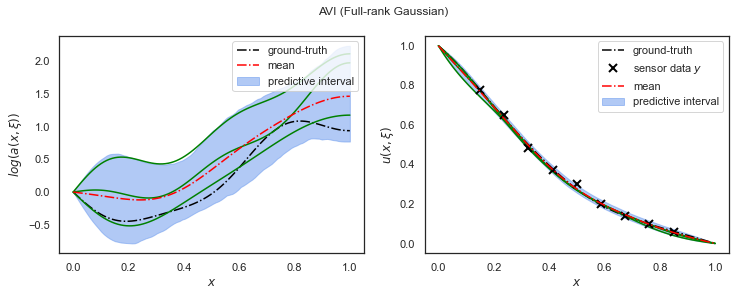

------------------------------------------------------------------------------------------
11_MCMC


Sample: 100%|██████████| 3300/3300 [02:07, 25.83it/s, step size=1.58e-01, acc. prob=0.899]


torch.Size([1000, 5])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]      0.55      0.28      0.56      0.12      1.02    916.88      1.00
  input[1]     -1.29      0.31     -1.29     -1.79     -0.78    994.59      1.00
  input[2]     -0.22      0.43     -0.22     -0.91      0.50   1184.23      1.00
  input[3]     -0.13      0.53     -0.13     -0.98      0.74   1312.56      1.00
  input[4]     -0.02      0.69     -0.01     -1.23      1.07   1185.99      1.00

Number of divergences: 0
None


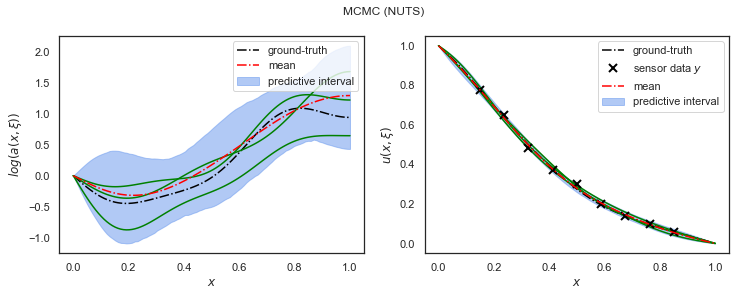

------------------------------------------------------------------------------------------


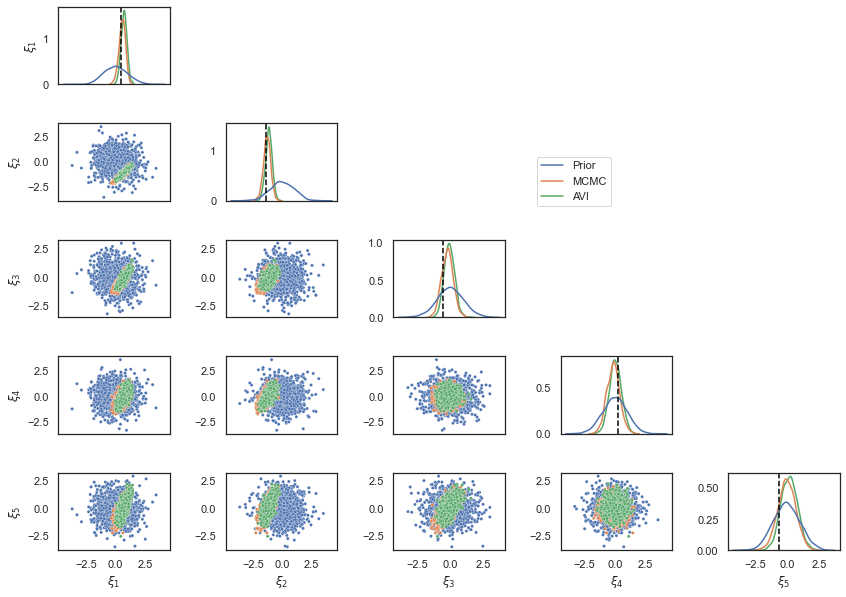

*****************************************************************************************************************************************************************************************
12
Groundtruth:
 xi_data=[[ 0.11490524  1.1775166  -0.6189497  -0.5095518   1.1651816 ]],
 y_data=[[0.8415486  0.78721523 0.6884729  0.64899725 0.6001028  0.5613871
  0.48885226 0.37827116 0.22451086]]
12_AVI
Estimated mean:
[-0.06827198  0.96984833 -0.6804073  -1.0125363   0.48079216]
Estimated covariance matrix:
[[0.06877521 0.07495425 0.08191197 0.09319108 0.09515856]
 [0.07495425 0.08603714 0.0875788  0.09111469 0.09557834]
 [0.08191197 0.0875788  0.12890998 0.11298209 0.0722918 ]
 [0.09319108 0.09111469 0.11298209 0.2434769  0.10291384]
 [0.09515856 0.09557834 0.0722918  0.10291384 0.3838667 ]]
torch.Size([1000, 5])


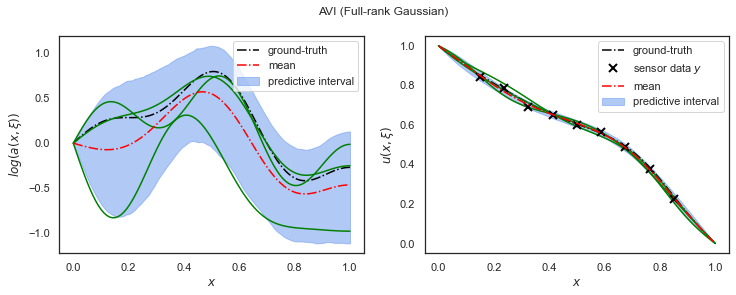

------------------------------------------------------------------------------------------
12_MCMC


Sample: 100%|██████████| 3300/3300 [03:15, 16.87it/s, step size=8.57e-02, acc. prob=0.952]


torch.Size([1000, 5])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]      0.02      0.28      0.03     -0.42      0.48    519.60      1.00
  input[1]      1.05      0.32      1.06      0.54      1.58    569.82      1.00
  input[2]     -0.62      0.39     -0.62     -1.25      0.05    694.31      1.00
  input[3]     -0.85      0.52     -0.85     -1.69     -0.02    656.66      1.00
  input[4]      0.82      0.65      0.82     -0.25      1.84    850.81      1.00

Number of divergences: 0
None


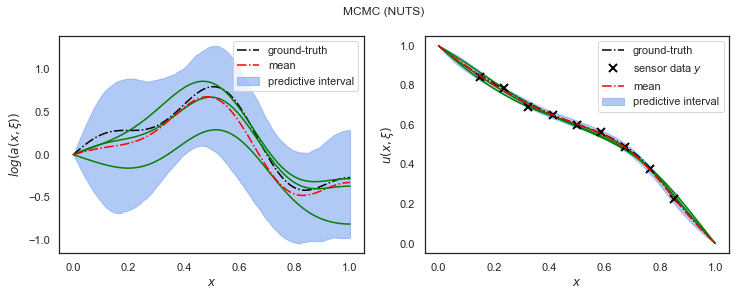

------------------------------------------------------------------------------------------


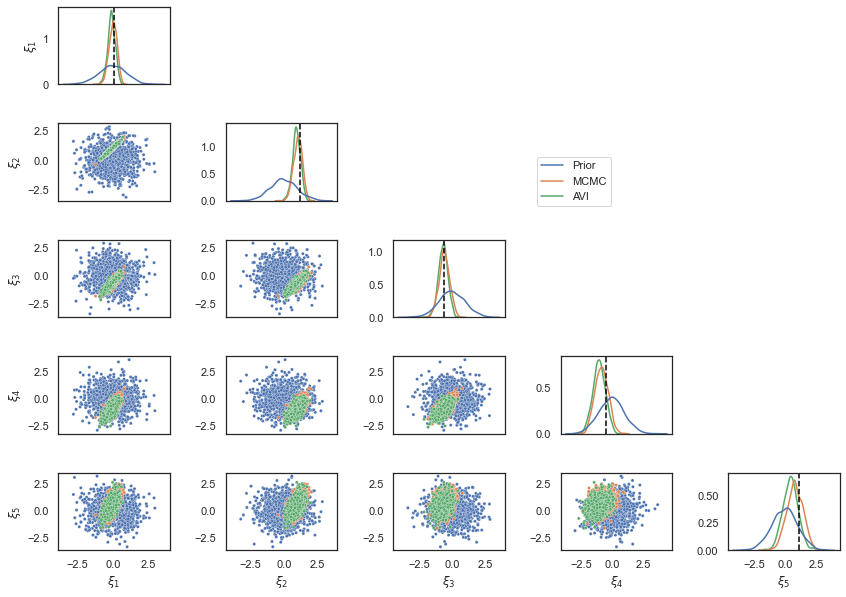

*****************************************************************************************************************************************************************************************
13
Groundtruth:
 xi_data=[[-1.9670703   0.9064985   0.80727345 -0.44357055  0.8257656 ]],
 y_data=[[0.9896949  0.97050136 0.94397575 0.9378555  0.90384954 0.8172333
  0.7050123  0.5009731  0.3034407 ]]
13_AVI
Estimated mean:
[-1.8019509   1.2549648   0.8117764  -0.8746409   0.20922607]
Estimated covariance matrix:
[[0.1260492  0.13617271 0.12306244 0.09174394 0.0275036 ]
 [0.13617271 0.15676822 0.14806397 0.10854236 0.01860672]
 [0.12306244 0.14806397 0.17522655 0.14730409 0.04390794]
 [0.09174394 0.10854236 0.14730409 0.26675466 0.16004948]
 [0.0275036  0.01860672 0.04390794 0.16004948 0.38554612]]
torch.Size([1000, 5])


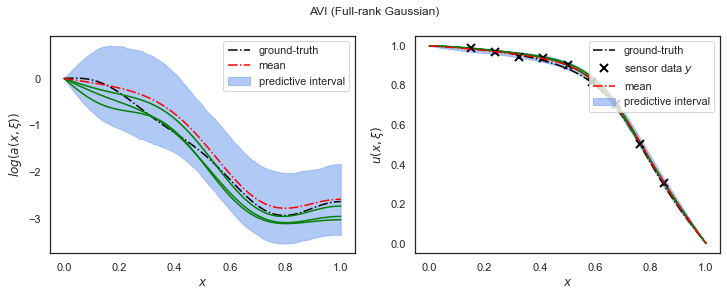

------------------------------------------------------------------------------------------
13_MCMC


Sample: 100%|██████████| 3300/3300 [02:34, 21.30it/s, step size=1.26e-01, acc. prob=0.929]


torch.Size([1000, 5])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]     -1.91      0.47     -1.89     -2.68     -1.16    861.34      1.00
  input[1]      1.12      0.50      1.12      0.28      1.91    819.32      1.00
  input[2]      0.80      0.51      0.77     -0.05      1.64    790.85      1.01
  input[3]     -0.70      0.63     -0.70     -1.75      0.30    883.36      1.01
  input[4]      0.31      0.67      0.28     -0.78      1.34   1330.02      1.00

Number of divergences: 0
None


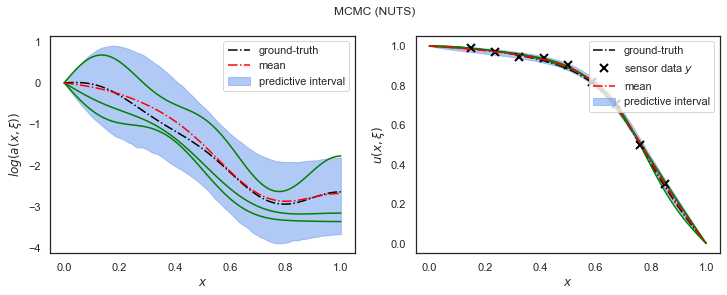

------------------------------------------------------------------------------------------


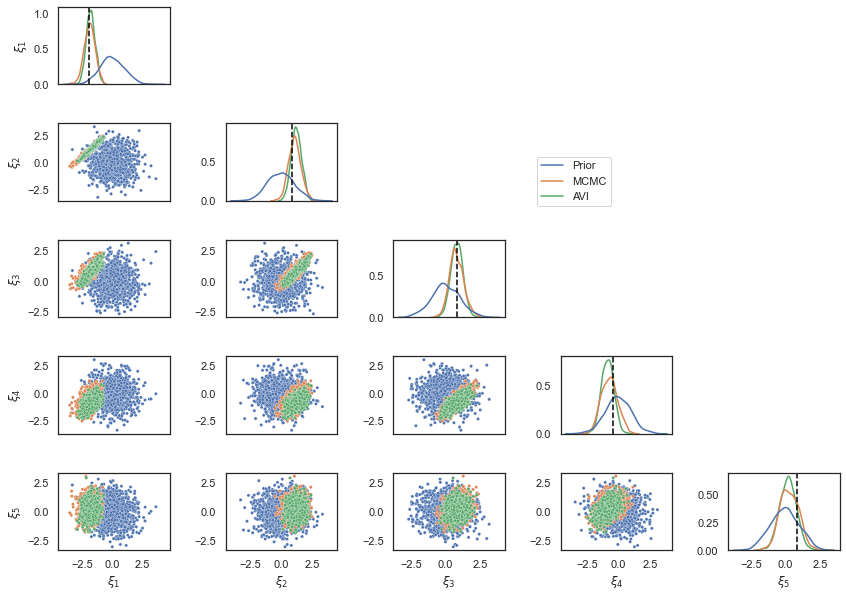

*****************************************************************************************************************************************************************************************
14
Groundtruth:
 xi_data=[[-0.27047768 -0.59012616 -0.7448506  -0.5212244  -0.6666939 ]],
 y_data=[[0.8284118  0.70187    0.59848326 0.5435206  0.4404297  0.36493042
  0.28907368 0.20485237 0.14718616]]
14_AVI
Estimated mean:
[ 0.22955526 -0.07023029 -0.1920833   0.11015393 -0.08908694]
Estimated covariance matrix:
[[0.06290199 0.07021064 0.07372108 0.07671654 0.09736773]
 [0.07021064 0.08295263 0.07746383 0.08685105 0.10753632]
 [0.07372108 0.07746383 0.11649526 0.06435721 0.10598353]
 [0.07671654 0.08685105 0.06435721 0.20610847 0.04773649]
 [0.09736773 0.10753632 0.10598353 0.04773649 0.36129457]]
torch.Size([1000, 5])


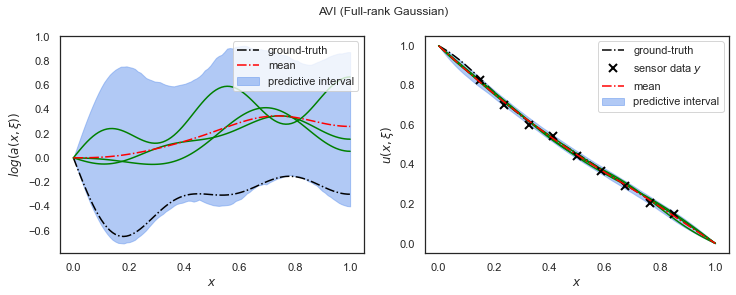

------------------------------------------------------------------------------------------
14_MCMC


Sample: 100%|██████████| 3300/3300 [02:48, 19.58it/s, step size=1.05e-01, acc. prob=0.938]


torch.Size([1000, 5])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]     -0.01      0.28     -0.01     -0.45      0.47    582.76      1.00
  input[1]     -0.38      0.31     -0.38     -0.85      0.19    595.29      1.00
  input[2]     -0.48      0.36     -0.48     -1.04      0.13    653.72      1.00
  input[3]     -0.18      0.50     -0.19     -1.08      0.59    965.83      1.00
  input[4]     -0.68      0.63     -0.69     -1.71      0.34    754.92      1.00

Number of divergences: 0
None


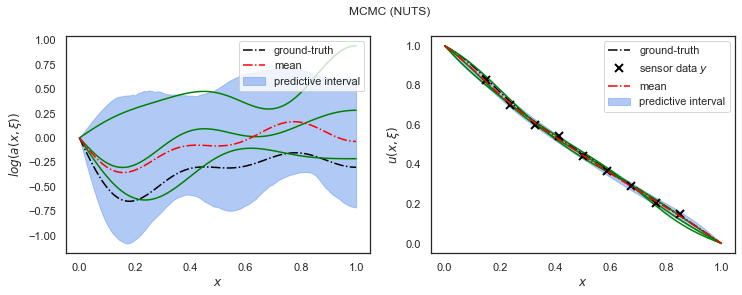

------------------------------------------------------------------------------------------


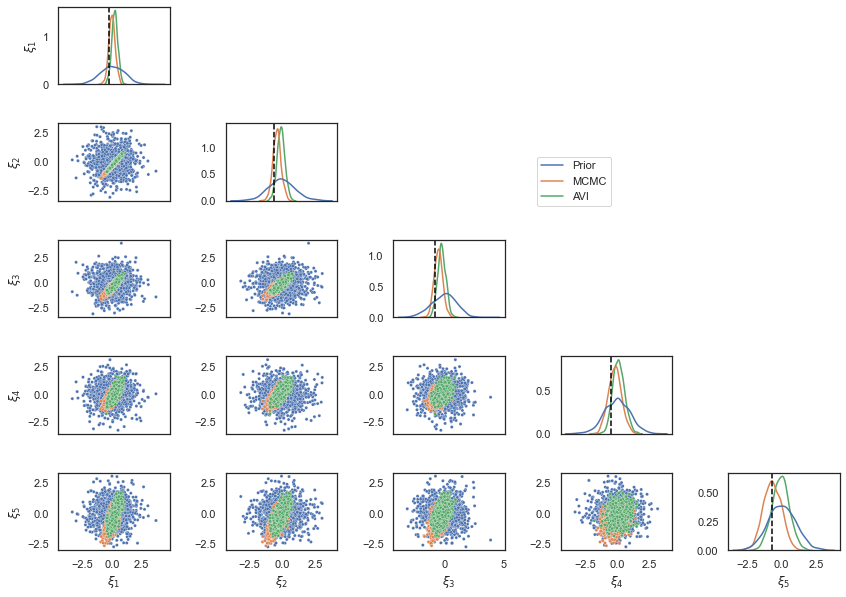

*****************************************************************************************************************************************************************************************
15
Groundtruth:
 xi_data=[[-0.22536623  0.64548934 -0.44118327 -0.3849407   1.0020926 ]],
 y_data=[[0.88502085 0.8263561  0.725791   0.6803263  0.61096674 0.5424614
  0.4984877  0.3825381  0.21163823]]
15_AVI
Estimated mean:
[-0.43095565  0.49637002 -0.66921914 -0.64984214  0.62539816]
Estimated covariance matrix:
[[0.07932562 0.08612806 0.08981049 0.09718477 0.09247914]
 [0.08612806 0.09664591 0.09598472 0.09964705 0.09340242]
 [0.08981049 0.09598472 0.12970807 0.11202089 0.07538451]
 [0.09718477 0.09964705 0.11202089 0.22450812 0.09652162]
 [0.09247914 0.09340242 0.07538451 0.09652162 0.37049064]]
torch.Size([1000, 5])


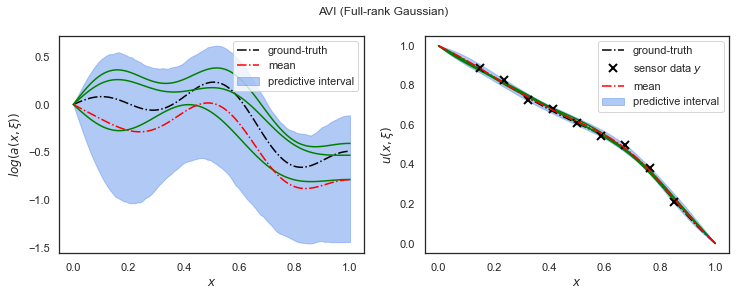

------------------------------------------------------------------------------------------
15_MCMC


Sample: 100%|██████████| 3300/3300 [03:13, 17.08it/s, step size=9.15e-02, acc. prob=0.940]


torch.Size([1000, 5])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]     -0.34      0.30     -0.32     -0.84      0.15    613.53      1.00
  input[1]      0.60      0.34      0.61      0.01      1.15    637.70      1.00
  input[2]     -0.64      0.39     -0.65     -1.27     -0.02    675.46      1.00
  input[3]     -0.54      0.48     -0.54     -1.34      0.22    750.10      1.00
  input[4]      1.20      0.65      1.20      0.24      2.37   1032.47      1.00

Number of divergences: 0
None


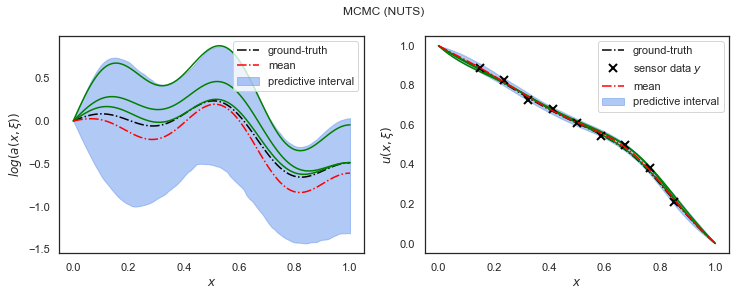

------------------------------------------------------------------------------------------


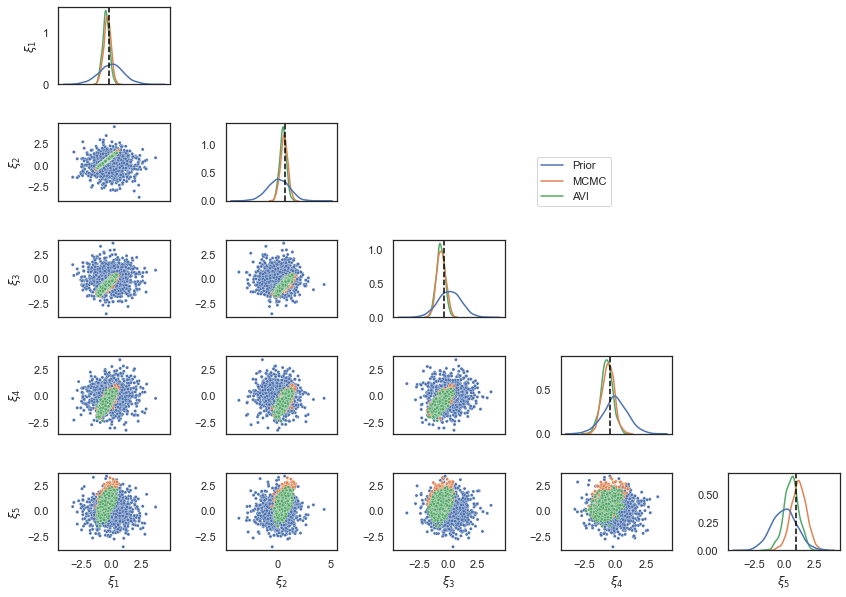

*****************************************************************************************************************************************************************************************
16
Groundtruth:
 xi_data=[[ 0.94576824  0.1195692  -0.3674649   0.04674974  0.05940468]],
 y_data=[[0.7079586  0.578623   0.48038003 0.41491747 0.31138438 0.2950103
  0.22681944 0.17422768 0.0941932 ]]
16_AVI
Estimated mean:
[ 0.87444115  0.11838688 -0.47631642 -0.48992258  0.05790175]
Estimated covariance matrix:
[[0.04929492 0.05348198 0.05599465 0.06327129 0.09552937]
 [0.05348198 0.06613097 0.0522786  0.06444472 0.11069239]
 [0.05599465 0.0522786  0.10966297 0.03597774 0.09090261]
 [0.06327129 0.06444472 0.03597774 0.23001905 0.0119109 ]
 [0.09552937 0.11069239 0.09090261 0.0119109  0.42989954]]
torch.Size([1000, 5])


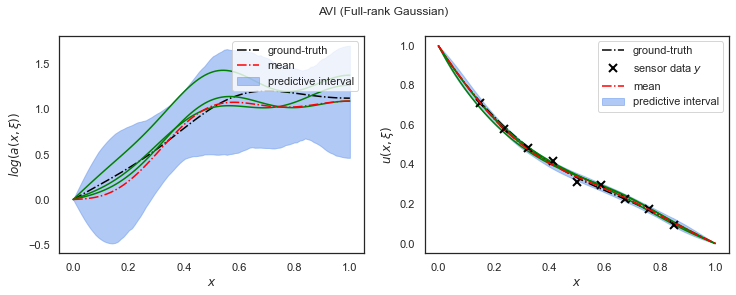

------------------------------------------------------------------------------------------
16_MCMC


Sample: 100%|██████████| 3300/3300 [02:18, 23.77it/s, step size=1.36e-01, acc. prob=0.924]


torch.Size([1000, 5])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]      1.00      0.23      1.01      0.64      1.38    696.16      1.00
  input[1]      0.22      0.27      0.23     -0.22      0.67    736.25      1.00
  input[2]     -0.26      0.36     -0.26     -0.83      0.32    955.10      1.00
  input[3]     -0.22      0.54     -0.23     -1.09      0.68   1077.69      1.00
  input[4]      0.21      0.73      0.23     -0.96      1.41    922.45      1.00

Number of divergences: 0
None


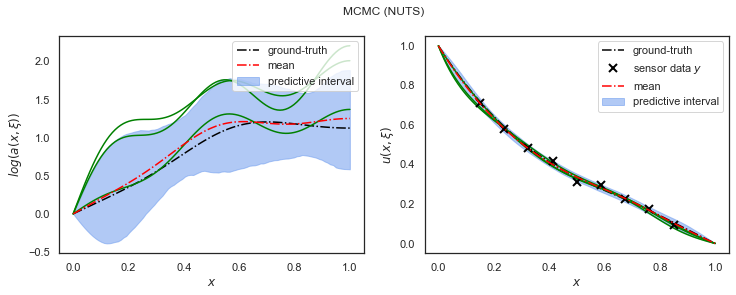

------------------------------------------------------------------------------------------


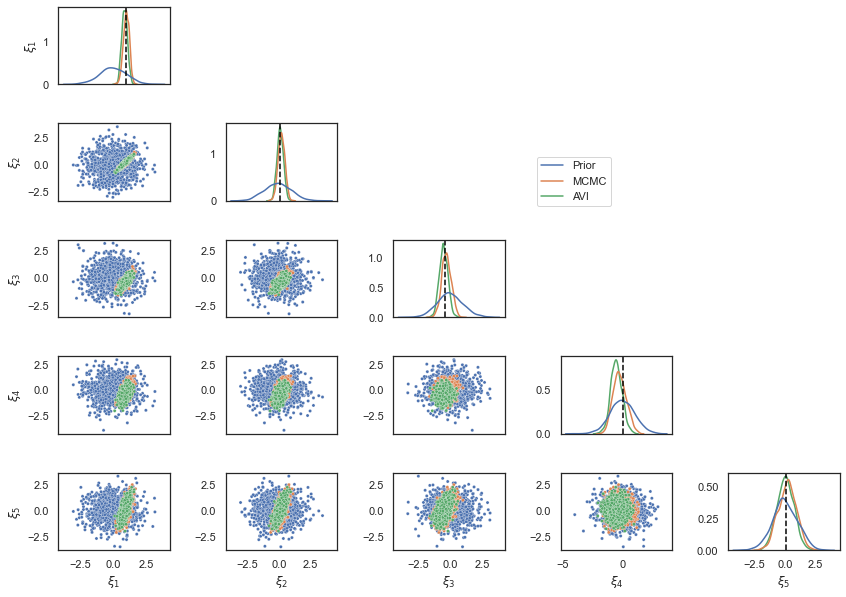

*****************************************************************************************************************************************************************************************
17
Groundtruth:
 xi_data=[[-2.1210165  -0.4444736   0.29369512 -0.1923251  -1.0978717 ]],
 y_data=[[0.98582697 0.9666189  0.90332794 0.86406124 0.76953983 0.6407597
  0.49741516 0.38672197 0.25195125]]
17_AVI
Estimated mean:
[-1.8345677  -0.04731958  0.70673156  0.88326985 -0.1691451 ]
Estimated covariance matrix:
[[0.12759976 0.13500549 0.11834295 0.09259303 0.03910588]
 [0.13500549 0.14811574 0.13475248 0.11179245 0.03395358]
 [0.11834295 0.13475248 0.15047601 0.13448013 0.06633677]
 [0.09259303 0.11179245 0.13448013 0.2642066  0.13242866]
 [0.03910588 0.03395358 0.06633677 0.13242866 0.4498097 ]]
torch.Size([1000, 5])


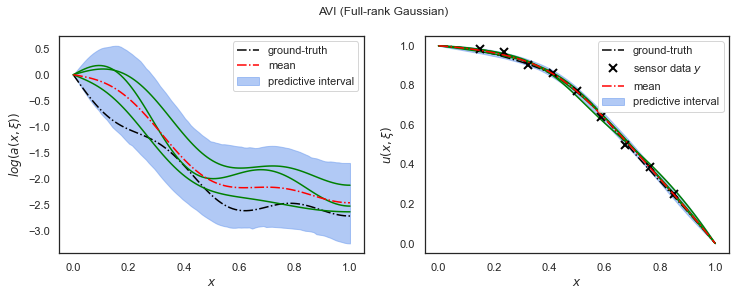

------------------------------------------------------------------------------------------
17_MCMC


Sample: 100%|██████████| 3300/3300 [03:20, 16.50it/s, step size=6.84e-02, acc. prob=0.942]


torch.Size([1000, 5])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]     -1.98      0.46     -1.96     -2.75     -1.26    669.01      1.00
  input[1]     -0.23      0.49     -0.22     -1.02      0.58    646.75      1.00
  input[2]      0.59      0.47      0.58     -0.19      1.33    656.25      1.00
  input[3]      0.86      0.59      0.86     -0.08      1.82    721.92      1.00
  input[4]     -0.58      0.69     -0.59     -1.73      0.55   1071.05      1.00

Number of divergences: 0
None


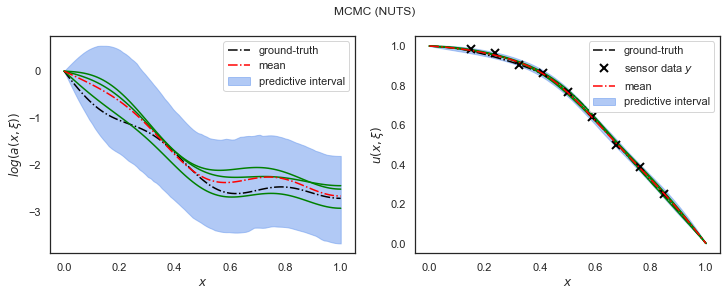

------------------------------------------------------------------------------------------


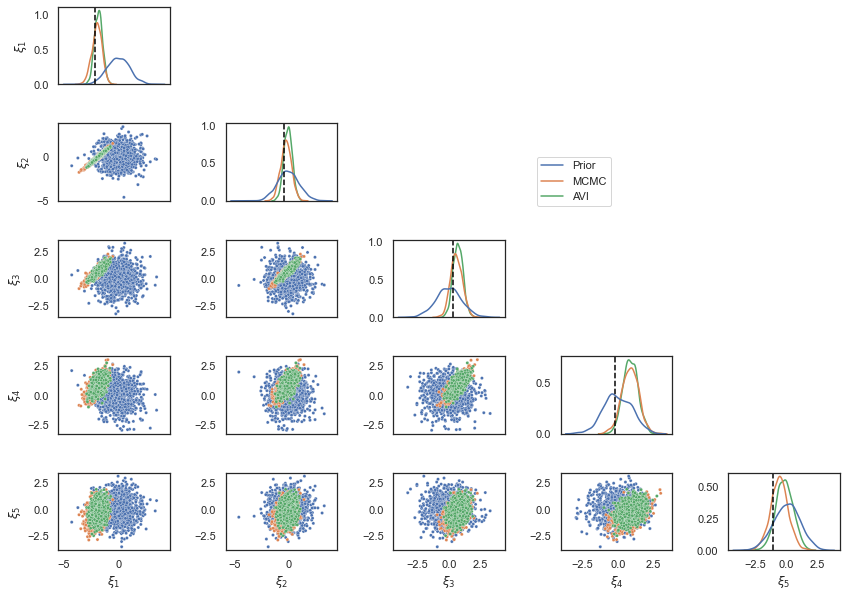

*****************************************************************************************************************************************************************************************
18
Groundtruth:
 xi_data=[[-1.4329859   0.3829131   0.05949217 -1.8187182  -0.6335351 ]],
 y_data=[[0.9334481  0.8960928  0.88121146 0.8447143  0.7858739  0.72330076
  0.5816617  0.39873368 0.25093988]]
18_AVI
Estimated mean:
[-0.9354222   0.9291616   0.6291945  -0.79561424  0.10702065]
Estimated covariance matrix:
[[0.09466626 0.10772084 0.11104034 0.10807003 0.0633911 ]
 [0.10772084 0.12752174 0.13090827 0.12404288 0.05640194]
 [0.11104034 0.13090827 0.16198085 0.15160684 0.06601319]
 [0.10807003 0.12404288 0.15160684 0.25404224 0.12013303]
 [0.0633911  0.05640194 0.06601319 0.12013303 0.3000058 ]]
torch.Size([1000, 5])


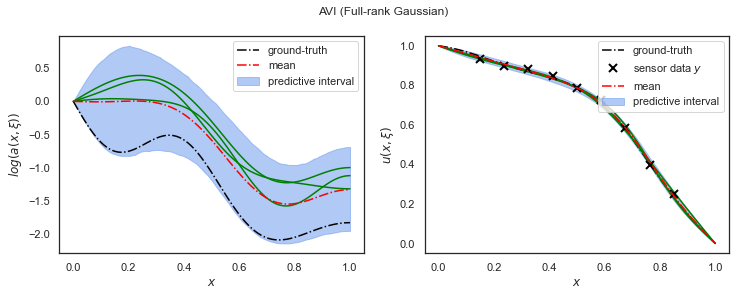

------------------------------------------------------------------------------------------
18_MCMC


Sample: 100%|██████████| 3300/3300 [03:01, 18.18it/s, step size=8.00e-02, acc. prob=0.946]


torch.Size([1000, 5])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]     -0.80      0.35     -0.78     -1.34     -0.22    592.53      1.00
  input[1]      1.15      0.42      1.16      0.43      1.80    632.55      1.00
  input[2]      0.88      0.48      0.88      0.12      1.70    617.28      1.00
  input[3]     -0.73      0.61     -0.71     -1.73      0.24    730.31      1.00
  input[4]     -0.20      0.61     -0.19     -1.16      0.83    925.53      1.00

Number of divergences: 0
None


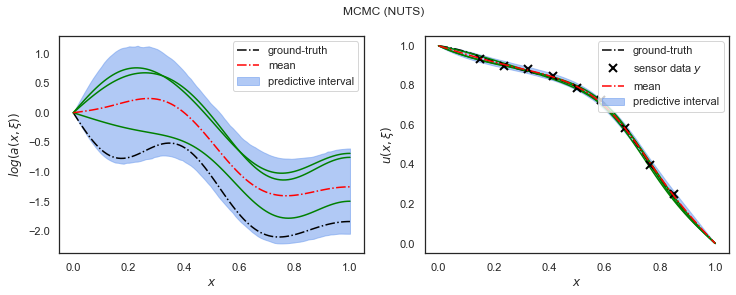

------------------------------------------------------------------------------------------


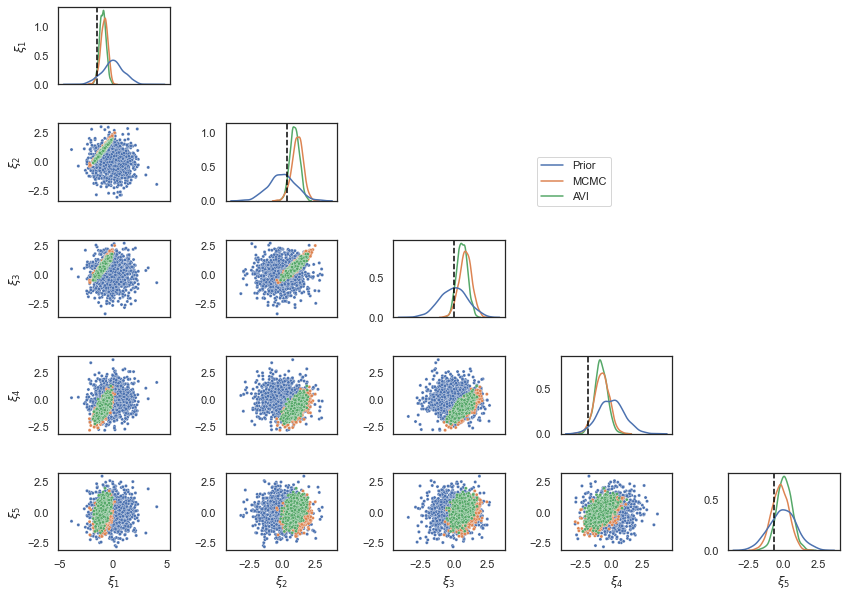

*****************************************************************************************************************************************************************************************
19
Groundtruth:
 xi_data=[[ 0.2019705 -0.4955786  1.9355187  2.110527   1.0979635]],
 y_data=[[0.9067436  0.8522285  0.76024973 0.63854253 0.45978564 0.3296085
  0.2112838  0.1397417  0.10639258]]
19_AVI
Estimated mean:
[-0.49258006 -1.2258332   0.999473    1.3570644  -0.4204242 ]
Estimated covariance matrix:
[[0.09629315 0.10464367 0.11855797 0.10757454 0.10575245]
 [0.10464367 0.12115327 0.12209628 0.13345765 0.09750106]
 [0.11855797 0.12209628 0.1740411  0.110984   0.15481393]
 [0.10757454 0.13345765 0.110984   0.24639212 0.06985708]
 [0.10575245 0.09750106 0.15481393 0.06985708 0.40948534]]
torch.Size([1000, 5])


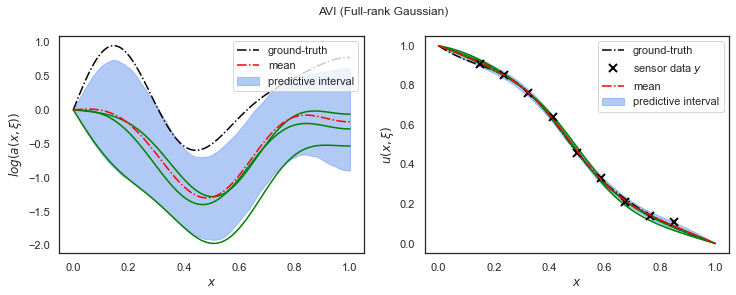

------------------------------------------------------------------------------------------
19_MCMC


Sample: 100%|██████████| 3300/3300 [02:39, 20.63it/s, step size=1.10e-01, acc. prob=0.942]


torch.Size([1000, 5])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]     -0.46      0.34     -0.45     -0.99      0.12    647.70      1.00
  input[1]     -1.16      0.38     -1.16     -1.77     -0.50    653.14      1.00
  input[2]      0.98      0.46      0.96      0.24      1.73    703.40      1.00
  input[3]      1.44      0.53      1.42      0.55      2.28    797.13      1.00
  input[4]     -0.52      0.71     -0.51     -1.62      0.64   1090.38      1.00

Number of divergences: 0
None


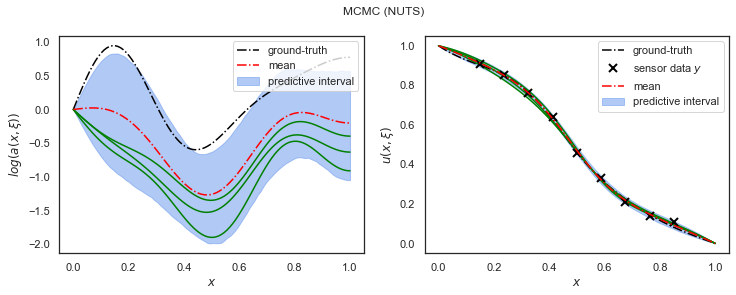

------------------------------------------------------------------------------------------


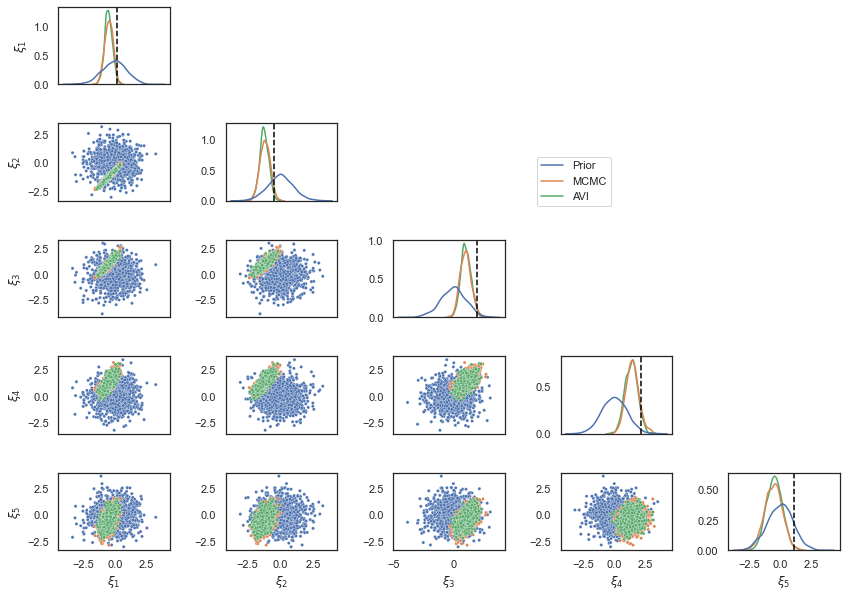

*****************************************************************************************************************************************************************************************


In [20]:
n_samples = 1000 # number of posterior samples

for j in range(y_data_.shape[0]): 
    print(j)
    
    # Getting data
    xi_data, y_data = xi_data_[j].reshape(1,-1), y_data_[j].reshape(1,-1)
    print('Groundtruth:\n xi_data='+str(xi_data.data.numpy())+',\n y_data='+str(y_data.data.numpy()))
    
    print(str(j)+'_AVI')
    # AVI_Full-rank-Gaussian
    mean = (model.mu(y_data))[0, :]
    L_diag = model.L_diag(y_data)
    L_offdiag = model.L_offdiag(y_data) #or 0.01*self.L_offdiag(y)
    L = unpack_cholesky(L_diag[0,:], L_offdiag[0,:], model.xi_dim) # L matrix

    print('Estimated mean:\n'+str(mean.data.numpy()))
    print('Estimated covariance matrix:\n'+str(torch.matmul(L,L.T).data.numpy()))

    xi_samples_AVI = torch.zeros(n_samples,model.xi_dim)
    for k in range(n_samples):
        zs = torch.randn_like(mean)
        xi_samples_AVI[k] = mean + torch.matmul(L, zs)
    print(xi_samples_AVI.shape)

    plot(xi_samples_AVI, xi_data, y_data, str(j)+'_AVI', "AVI (Full-rank Gaussian)") 
    print('-'*90)

    print(str(j)+'_MCMC')
    # MCMC
    def model_MCMC(data):
        xi = pyro.sample( "input", dist_pyro.Normal(loc=torch.zeros(d_xi), scale=torch.ones(d_xi)) )
        pyro.sample("obs", dist_pyro.Normal(forward_process(xi), noise_scale), obs=data)

    hmc_kernel = HMC(model_MCMC, step_size=0.0855, num_steps=4)
    nuts_kernel= NUTS(model_MCMC, adapt_step_size=True)
    mcmc = MCMC(nuts_kernel, num_samples=int(n_samples*3), warmup_steps=300, num_chains=1)
    mcmc.run(y_data[0])
    
    thin = 3 #adjacent MCMC samples are correlated so computationally it can make sense to throw some samples out.
    xi_samples_MCMC = mcmc.get_samples()['input'][::thin,:]
    print(xi_samples_MCMC.shape)

    print(mcmc.summary())
    plot(xi_samples_MCMC, xi_data, y_data, str(j)+'_MCMC', "MCMC (NUTS)")
    print('-'*90)    
    
    ######
    Prior_data = prior_xi_dist.sample([n_samples]).T.data.numpy()
    Prior_dict = dict() 
    for i in range(Prior_data.shape[0]):
        Prior_dict[r'$\xi_{%.0f}$' % (i+1)] = Prior_data[i] 

    AVI_data = xi_samples_AVI.T.data.numpy()
    AVI_dict = dict() 
    for i in range(AVI_data.shape[0]):
        AVI_dict[r'$\xi_{%.0f}$' % (i+1)] = AVI_data[i]  

    MCMC_data = xi_samples_MCMC.T.data.numpy()
    MCMC_dict = dict() 
    for i in range(MCMC_data.shape[0]):
        MCMC_dict[r'$\xi_{%.0f}$' % (i+1)] = MCMC_data[i]    

    df_Prior = pd.DataFrame(Prior_dict)
    df_MCMC = pd.DataFrame(MCMC_dict)
    df_AVI = pd.DataFrame(AVI_dict)
    df_Prior['Sample type'] = 'Prior'
    df_MCMC['Sample type'] = 'MCMC'
    df_AVI['Sample type'] = 'AVI'

    df = pd.concat([df_Prior, df_MCMC, df_AVI])
    df.reset_index(drop=True, inplace=True)
    pair_plot(df, xi_data, j)
    ######   
    
    print('*'*185)  

In [21]:
!zip -r ./results.zip ./results

  adding: results/ (stored 0%)
  adding: results/7_MCMC_plot.pdf (deflated 24%)
  adding: results/3_MCMC_plot.pdf (deflated 24%)
  adding: results/3_AVI_xi_samples.pt (deflated 9%)
  adding: results/11_MCMC_plot.pdf (deflated 24%)
  adding: results/19_AVI_plot.pdf (deflated 25%)
  adding: results/8_pairplot.pdf (deflated 2%)
  adding: results/15_MCMC_plot.pdf (deflated 24%)
  adding: results/6_AVI_xi_samples.pt (deflated 9%)
  adding: results/8_MCMC_xi_samples.pt (deflated 9%)
  adding: results/5_MCMC_xi_samples.pt (deflated 8%)
  adding: results/16_MCMC_xi_samples.pt (deflated 8%)
  adding: results/12_MCMC_plot.pdf (deflated 24%)
  adding: results/15_MCMC_xi_samples.pt (deflated 8%)
  adding: results/6_MCMC_xi_samples.pt (deflated 8%)
  adding: results/18_MCMC_xi_samples.pt (deflated 9%)
  adding: results/16_MCMC_plot.pdf (deflated 24%)
  adding: results/2_AVI_xi_samples.pt (deflated 10%)
  adding: results/4_MCMC_plot.pdf (deflated 24%)
  adding: results/18_AVI_plot.pdf (deflated 25%)

In [22]:
noise_scale

0.015